https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.2


In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [22]:
df_raw = pd.read_csv('Data/2010_animation_ratings.csv')
df_raw.head()

userId  movieId  rating   timestamp  \
0     177    78637     2.5  1435837464   
1     514    76093     4.0  1533872585   
2     252    78499     5.0  1498284330   
3     567    76093     2.5  1525287804   
4     586    81847     4.5  1529903135   

                                               title  Group_Number  
0  Shrek Forever After (a.k.a. Shrek: The Final C...             3  
1                    How to Train Your Dragon (2010)             1  
2                                 Toy Story 3 (2010)             2  
3                    How to Train Your Dragon (2010)             1  
4                                     Tangled (2010)             8

In [23]:
df = df_raw.drop(columns=['userId', 'movieId', 'timestamp'])

print("The dataset contains {} unique movie titles.".format(df['title'].nunique()))

df.head()

The dataset contains 8 unique movie titles.


rating                                              title  Group_Number
0     2.5  Shrek Forever After (a.k.a. Shrek: The Final C...             3
1     4.0                    How to Train Your Dragon (2010)             1
2     5.0                                 Toy Story 3 (2010)             2
3     2.5                    How to Train Your Dragon (2010)             1
4     4.5                                     Tangled (2010)             8

In [24]:
# Manually create a dictionary mapping full titles to short titles
title_to_short = {
    'Shrek Forever After (a.k.a. Shrek: The Final Chapter) (2010)': 'Shrek',
    'How to Train Your Dragon (2010)': 'Dragon',
    'Toy Story 3 (2010)': 'Toy_Story',
    'Tangled (2010)': 'Tangled',
    'Despicable Me (2010)': 'Despicable_me',
    'Legend of the Guardians: The Owls of Ga\'Hoole (2010)': 'Guardians',
    'Megamind (2010)': 'Megamind',
    'Batman: Under the Red Hood (2010)': 'Batman'
}

# Create a new column 'short_title' by mapping the 'title' column through the dictionary
df['title'] = df['title'].map(title_to_short)

titles = df['title'].unique()

title_to_ratings = {title: df[df['title'] == title]['rating'].values for title in titles}

# Display the DataFrame to verify the new column
df.head()

rating      title  Group_Number
0     2.5      Shrek             3
1     4.0     Dragon             1
2     5.0  Toy_Story             2
3     2.5     Dragon             1
4     4.5    Tangled             8

In [25]:
# Aggregate statistics
observed_stats = df.groupby('title').rating.agg(['mean', 'std']).reset_index()
observed_stats.columns = ['title', 'mean', 'std']
observed_stats

title      mean       std
0         Batman  5.000000       NaN
1  Despicable_me  3.722222  0.618017
2         Dragon  3.409091  0.860761
3      Guardians  4.000000       NaN
4       Megamind  3.375000  1.314978
5          Shrek  4.000000  1.322876
6        Tangled  4.200000  0.888194
7      Toy_Story  3.812500  0.963933

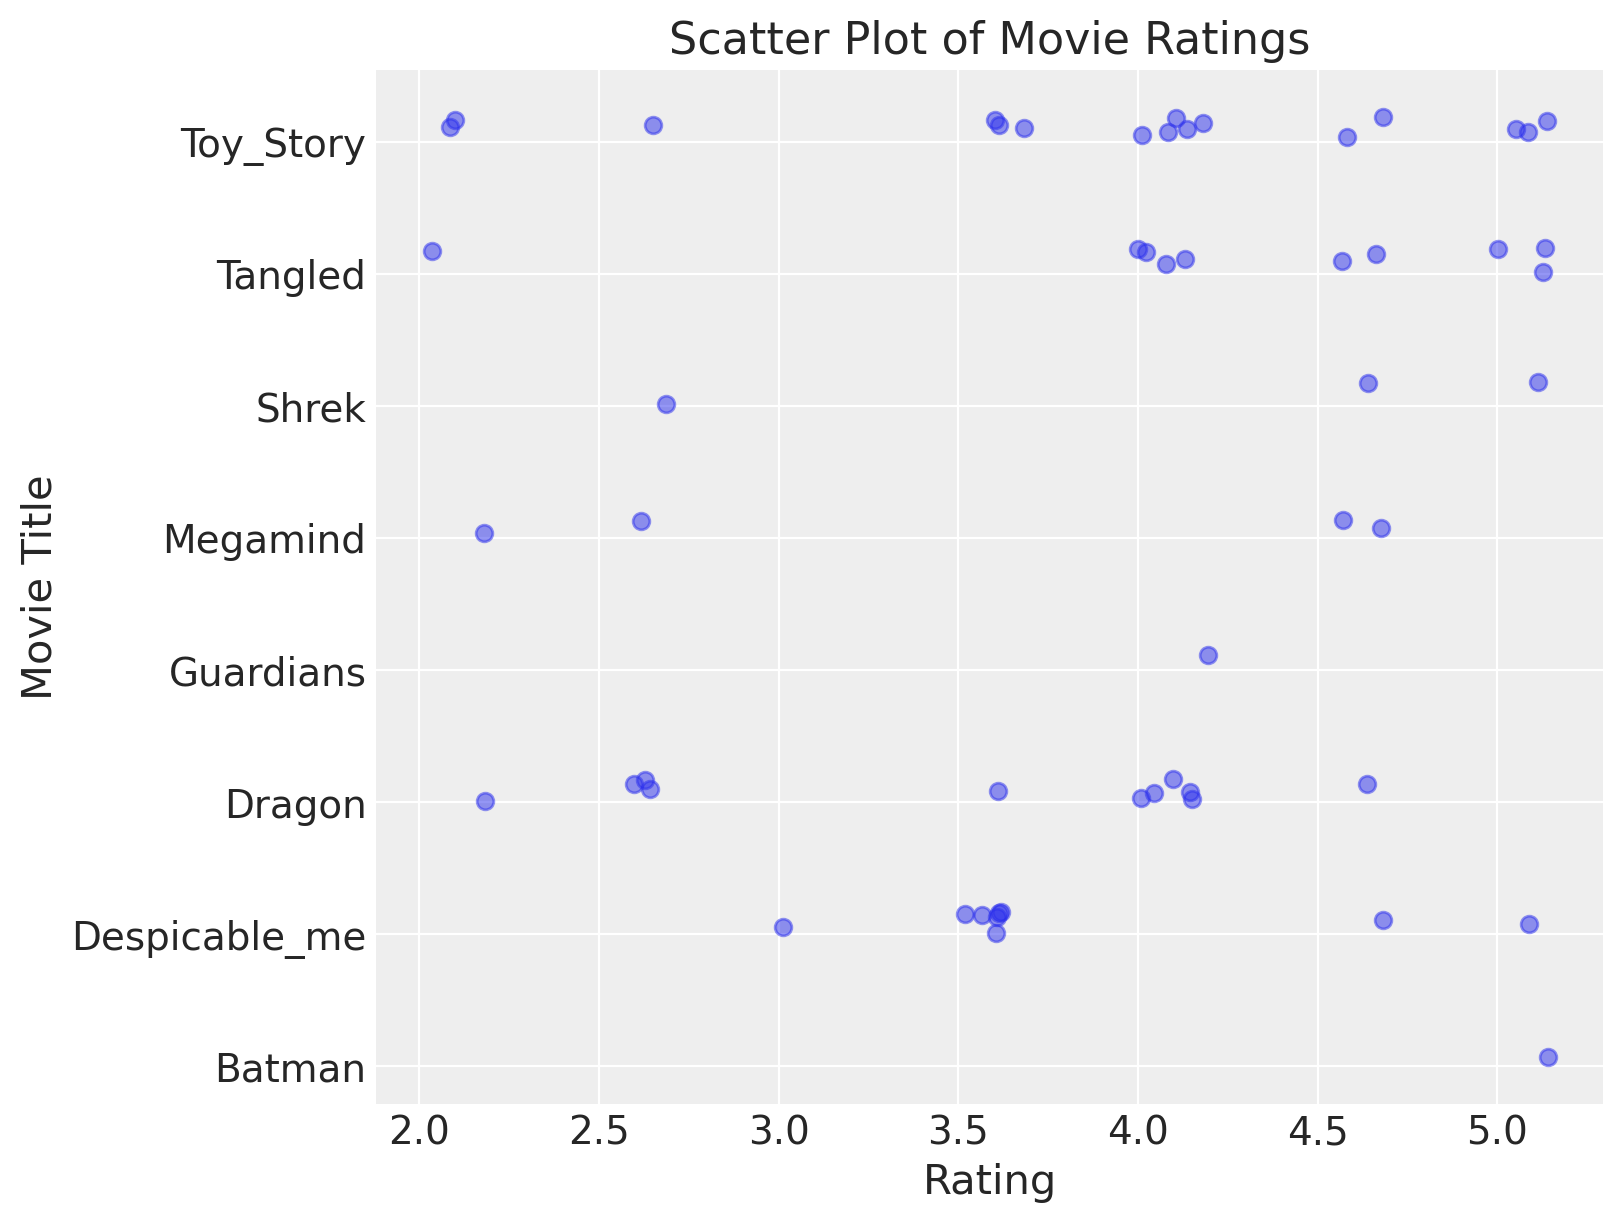

In [8]:
# Create a numeric category for movie titles
df['title_cat'] = pd.Categorical(df['title']).codes

# Generating jitter for the x-axis
x_jitter = 0.2 * np.random.rand(len(df))  # Adjust 0.1 to increase or decrease the jitter
y_jitter = 0.2 * np.random.rand(len(df))  # Jitter for y-axis, similar scale as x-axis

# Set up the plot
plt.figure(figsize=(8, 6))

# Creating the scatter plot
plt.scatter(df['rating'] + x_jitter, df['title_cat'] + y_jitter, alpha=0.5)

# Setting the x-axis to show movie titles instead of numbers
plt.yticks(df['title_cat'].unique(), df['title'].unique(), rotation=0)

plt.title('Scatter Plot of Movie Ratings')
plt.ylabel('Movie Title')
plt.xlabel('Rating')

# Show the plot
#plt.tight_layout()  # Adjust layout to make sure labels are readable
plt.show()

# Build the simplest model: a Normal Model

In [9]:
from pymc import Model, Normal, Gamma, Deterministic, sample, HalfNormal, InverseGamma, LogNormal, Uniform

with Model() as model_0:
    # Define the priors
    mu = Uniform("mu", lower=1, upper=5)
    sigma = InverseGamma('sigma', alpha=3, beta=1) # Keep the width of the normal distribution narrow, in order not to get values < 1 or > 5b

    # Define likelihood
    model = Normal('model', mu=mu, sigma=sigma, observed=df.rating.values)

    # Inference!
    idata_0 = sample(3000, return_inferencedata=True, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


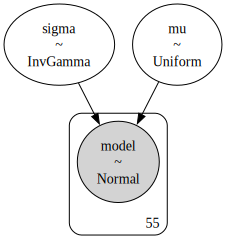

In [10]:
pm.model_to_graphviz(model_0)

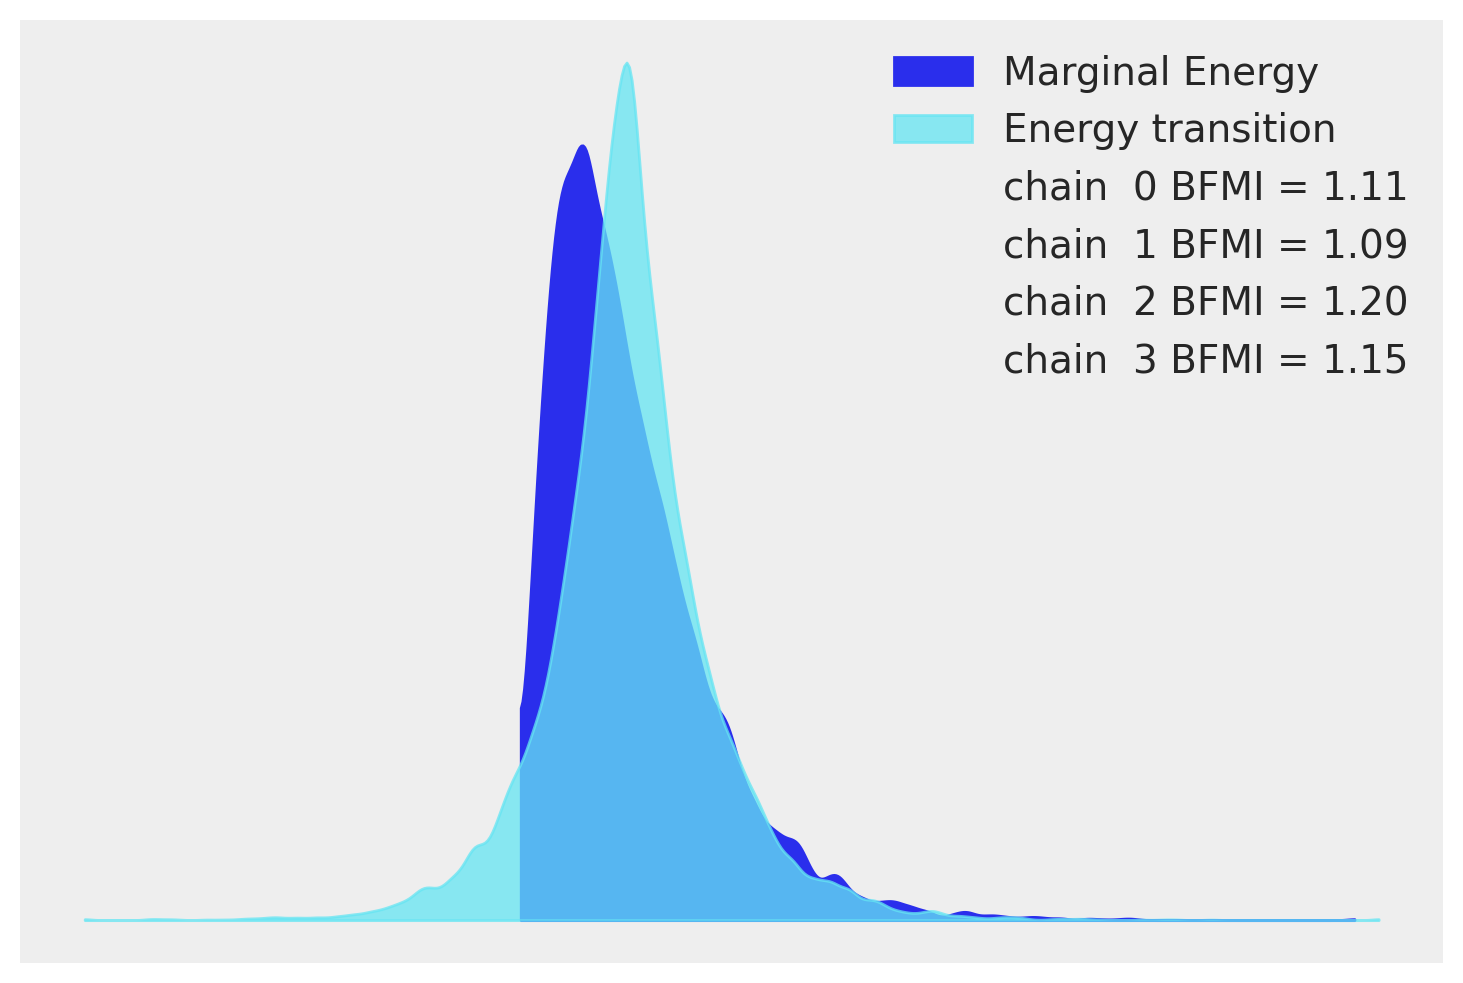

In [11]:
az.plot_energy(idata_0);

### Prior Predictive checks

In [12]:
# Prior predictive check

with model_0:
    prior_check_0 = pm.sample_prior_predictive(samples=1000)

Sampling: [model, mu, sigma]


In [13]:
prior_predictive_distribution_0 = prior_check_0.prior_predictive['model'].values

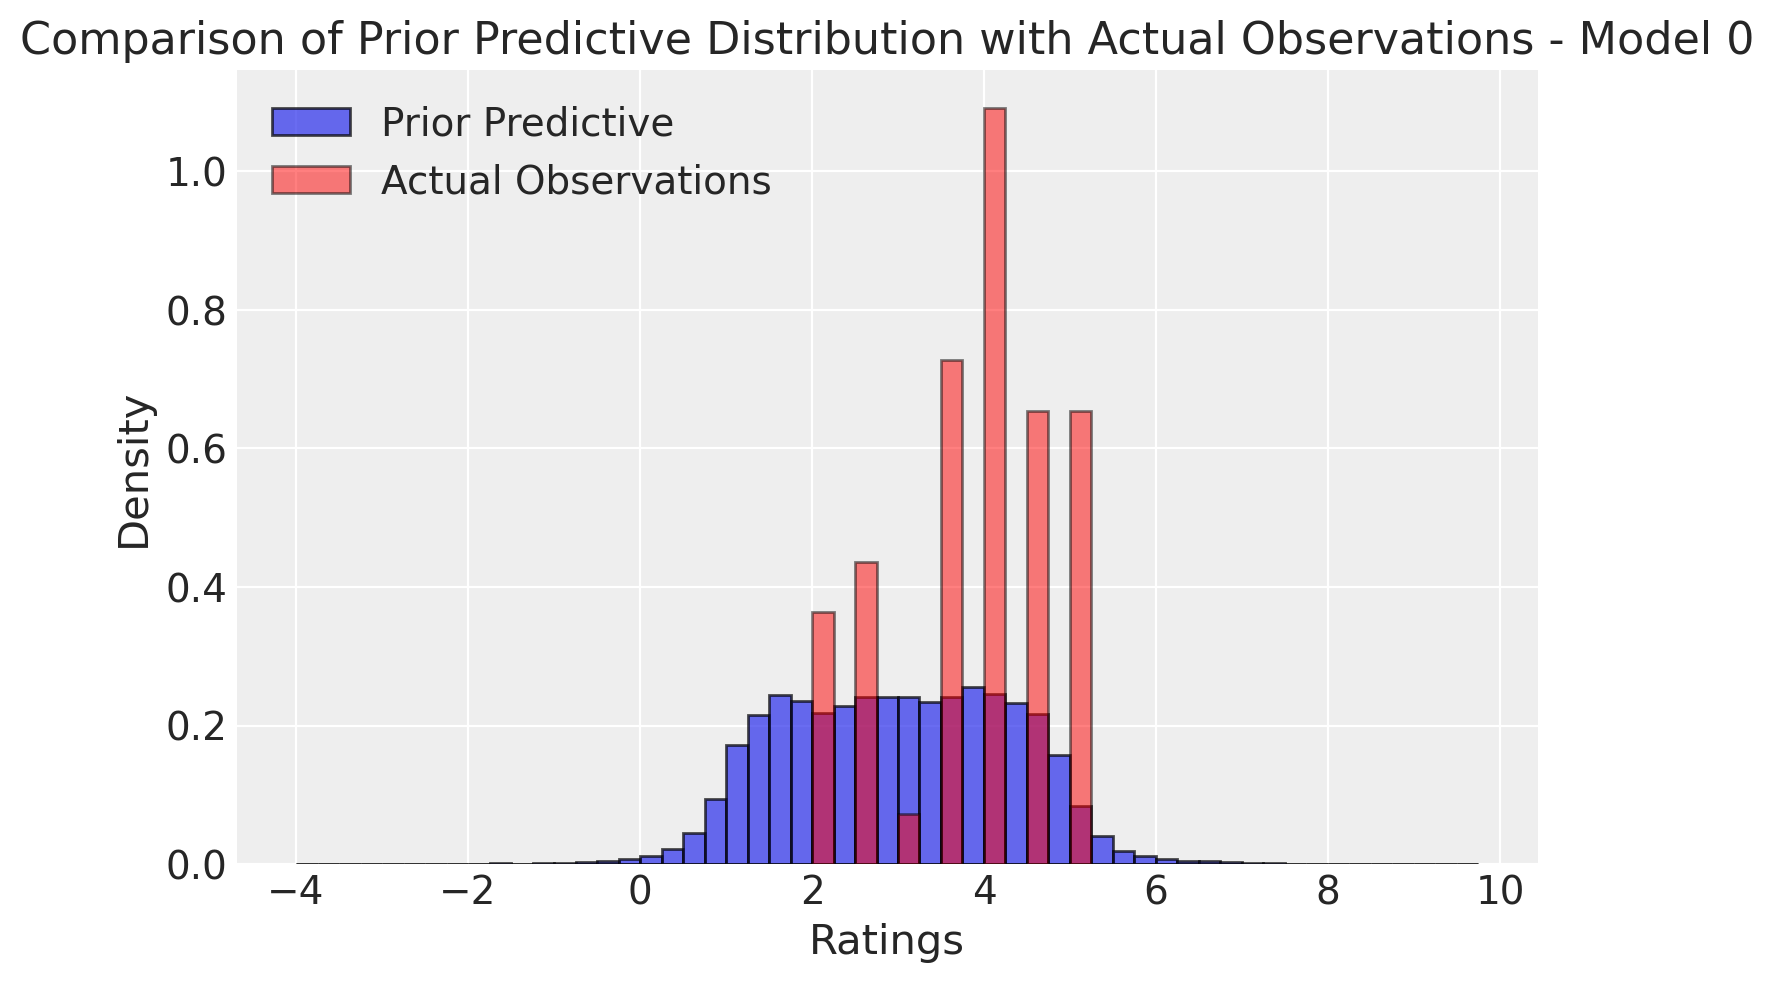

In [14]:
# Assuming 'prior_predictive_distribution' is your array of data from the prior predictive checks
bins = np.arange(-4, 10, 0.25)

# Calculate the histogram density for the prior predictive distribution
frq_prior, edges = np.histogram(prior_predictive_distribution_0, bins, density=True)
widths = np.diff(edges)  # Width of each bin

fig, ax = plt.subplots()
# Plot the prior predictive distribution as a bar with density normalization
ax.bar(edges[:-1], frq_prior, width=widths, edgecolor="black", align="edge", alpha=0.7, label='Prior Predictive')

# Calculate the histogram density for actual observations
frq_obs, _ = np.histogram(df.rating.values, bins, density=True)
# Overlay the actual observations with density normalization
ax.bar(edges[:-1], frq_obs, width=widths, edgecolor="black", align="edge", alpha=0.5, color='red', label='Actual Observations')

# Adding labels and legend
ax.set_xlabel('Ratings')
ax.set_ylabel('Density')
ax.set_title('Comparison of Prior Predictive Distribution with Actual Observations - Model 0')
ax.legend()

plt.show()

### Posterior predictive check

In [15]:
# Posterior predictive check

with model_0:
    posterior_check_0 = pm.sample_posterior_predictive(idata_0)

Sampling: [model]


In [16]:
posterior_predictive_distribution_0 = posterior_check_0.posterior_predictive['model'].values

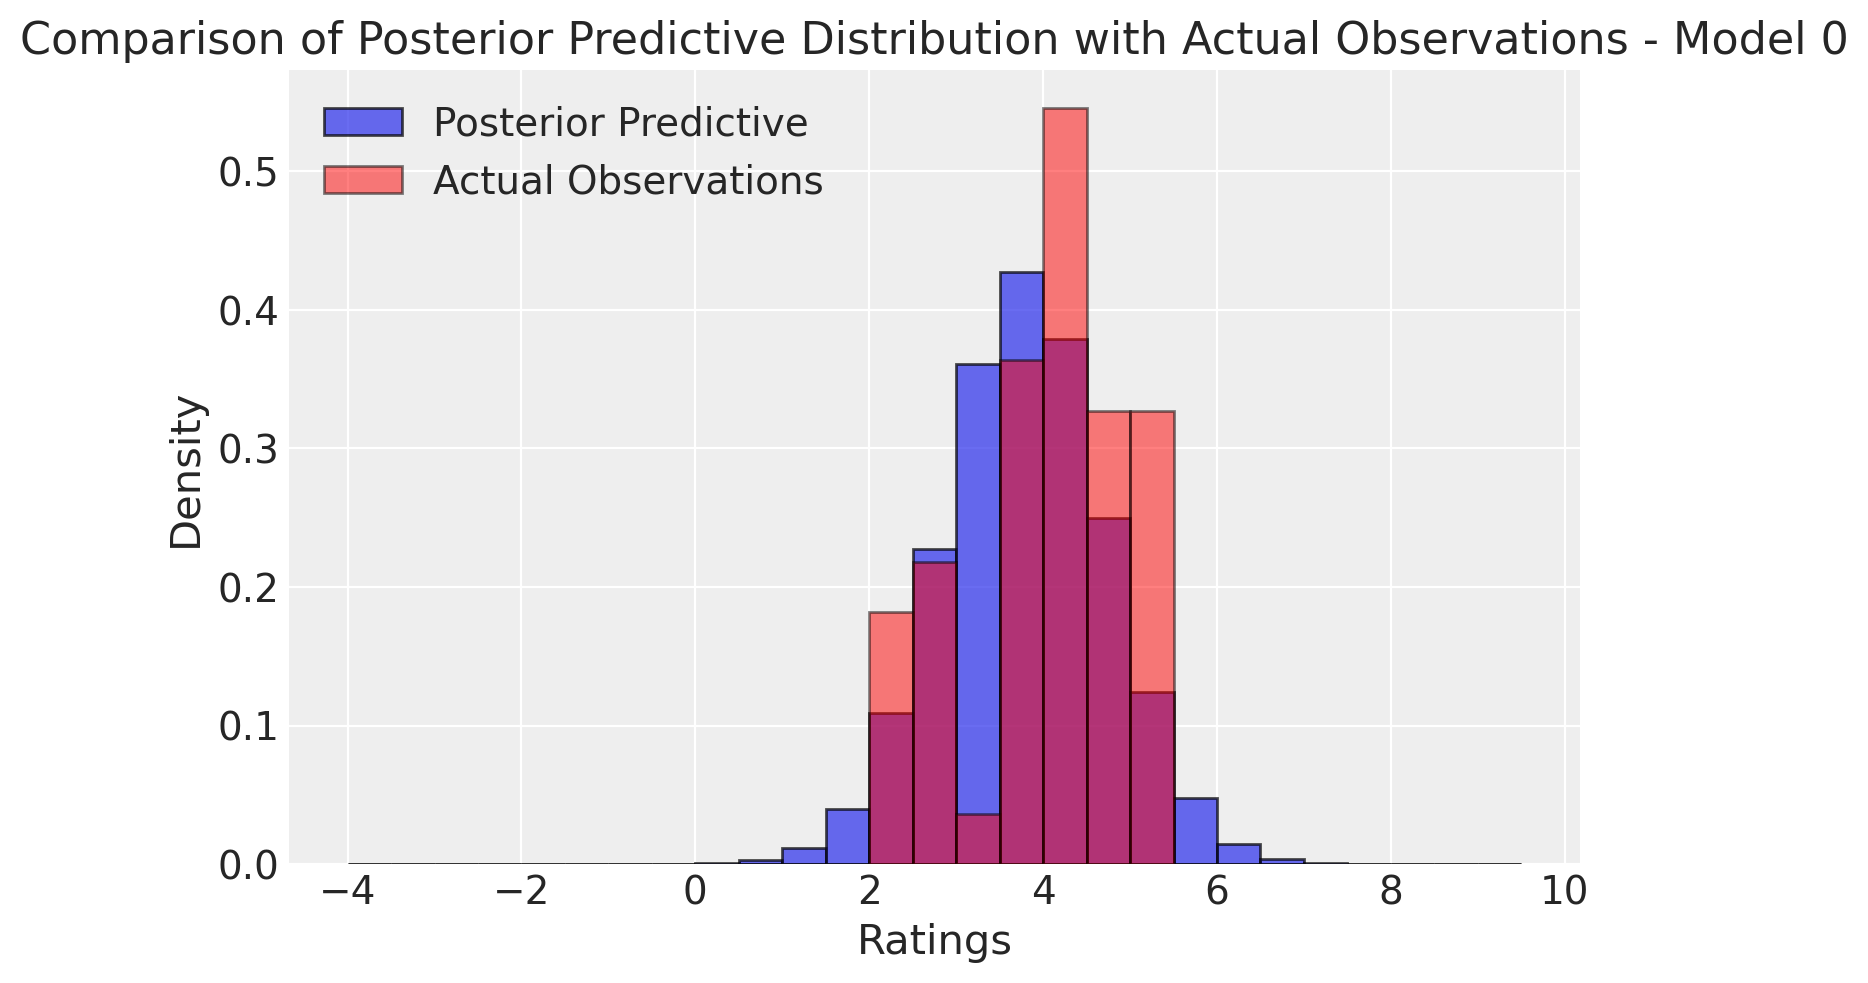

In [17]:
# Assuming 'prior_predictive_distribution' is your array of data from the prior predictive checks
bins = np.arange(-4, 10, 0.5)

# Calculate the histogram density for the prior predictive distribution
frq_posterior, edges = np.histogram(posterior_predictive_distribution_0, bins, density=True)
widths = np.diff(edges)  # Width of each bin

fig, ax = plt.subplots()
# Plot the prior predictive distribution as a bar with density normalization
ax.bar(edges[:-1], frq_posterior, width=widths, edgecolor="black", align="edge", alpha=0.7, label='Posterior Predictive')

# Calculate the histogram density for actual observations
frq_obs, _ = np.histogram(df.rating.values, bins, density=True)
# Overlay the actual observations with density normalization
ax.bar(edges[:-1], frq_obs, width=widths, edgecolor="black", align="edge", alpha=0.5, color='red', label='Actual Observations')

# Adding labels and legend
ax.set_xlabel('Ratings')
ax.set_ylabel('Density')
ax.set_title('Comparison of Posterior Predictive Distribution with Actual Observations - Model 0')
ax.legend()

plt.show()

## Inference

In [18]:
# Check the trace summary for results

summary_0 = pm.summary(idata_0)
summary_0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     3.790  0.124   3.554    4.023      0.001    0.001   10144.0    6846.0   
sigma  0.918  0.088   0.753    1.079      0.001    0.001   11522.0    8459.0   

       r_hat  
mu       1.0  
sigma    1.0

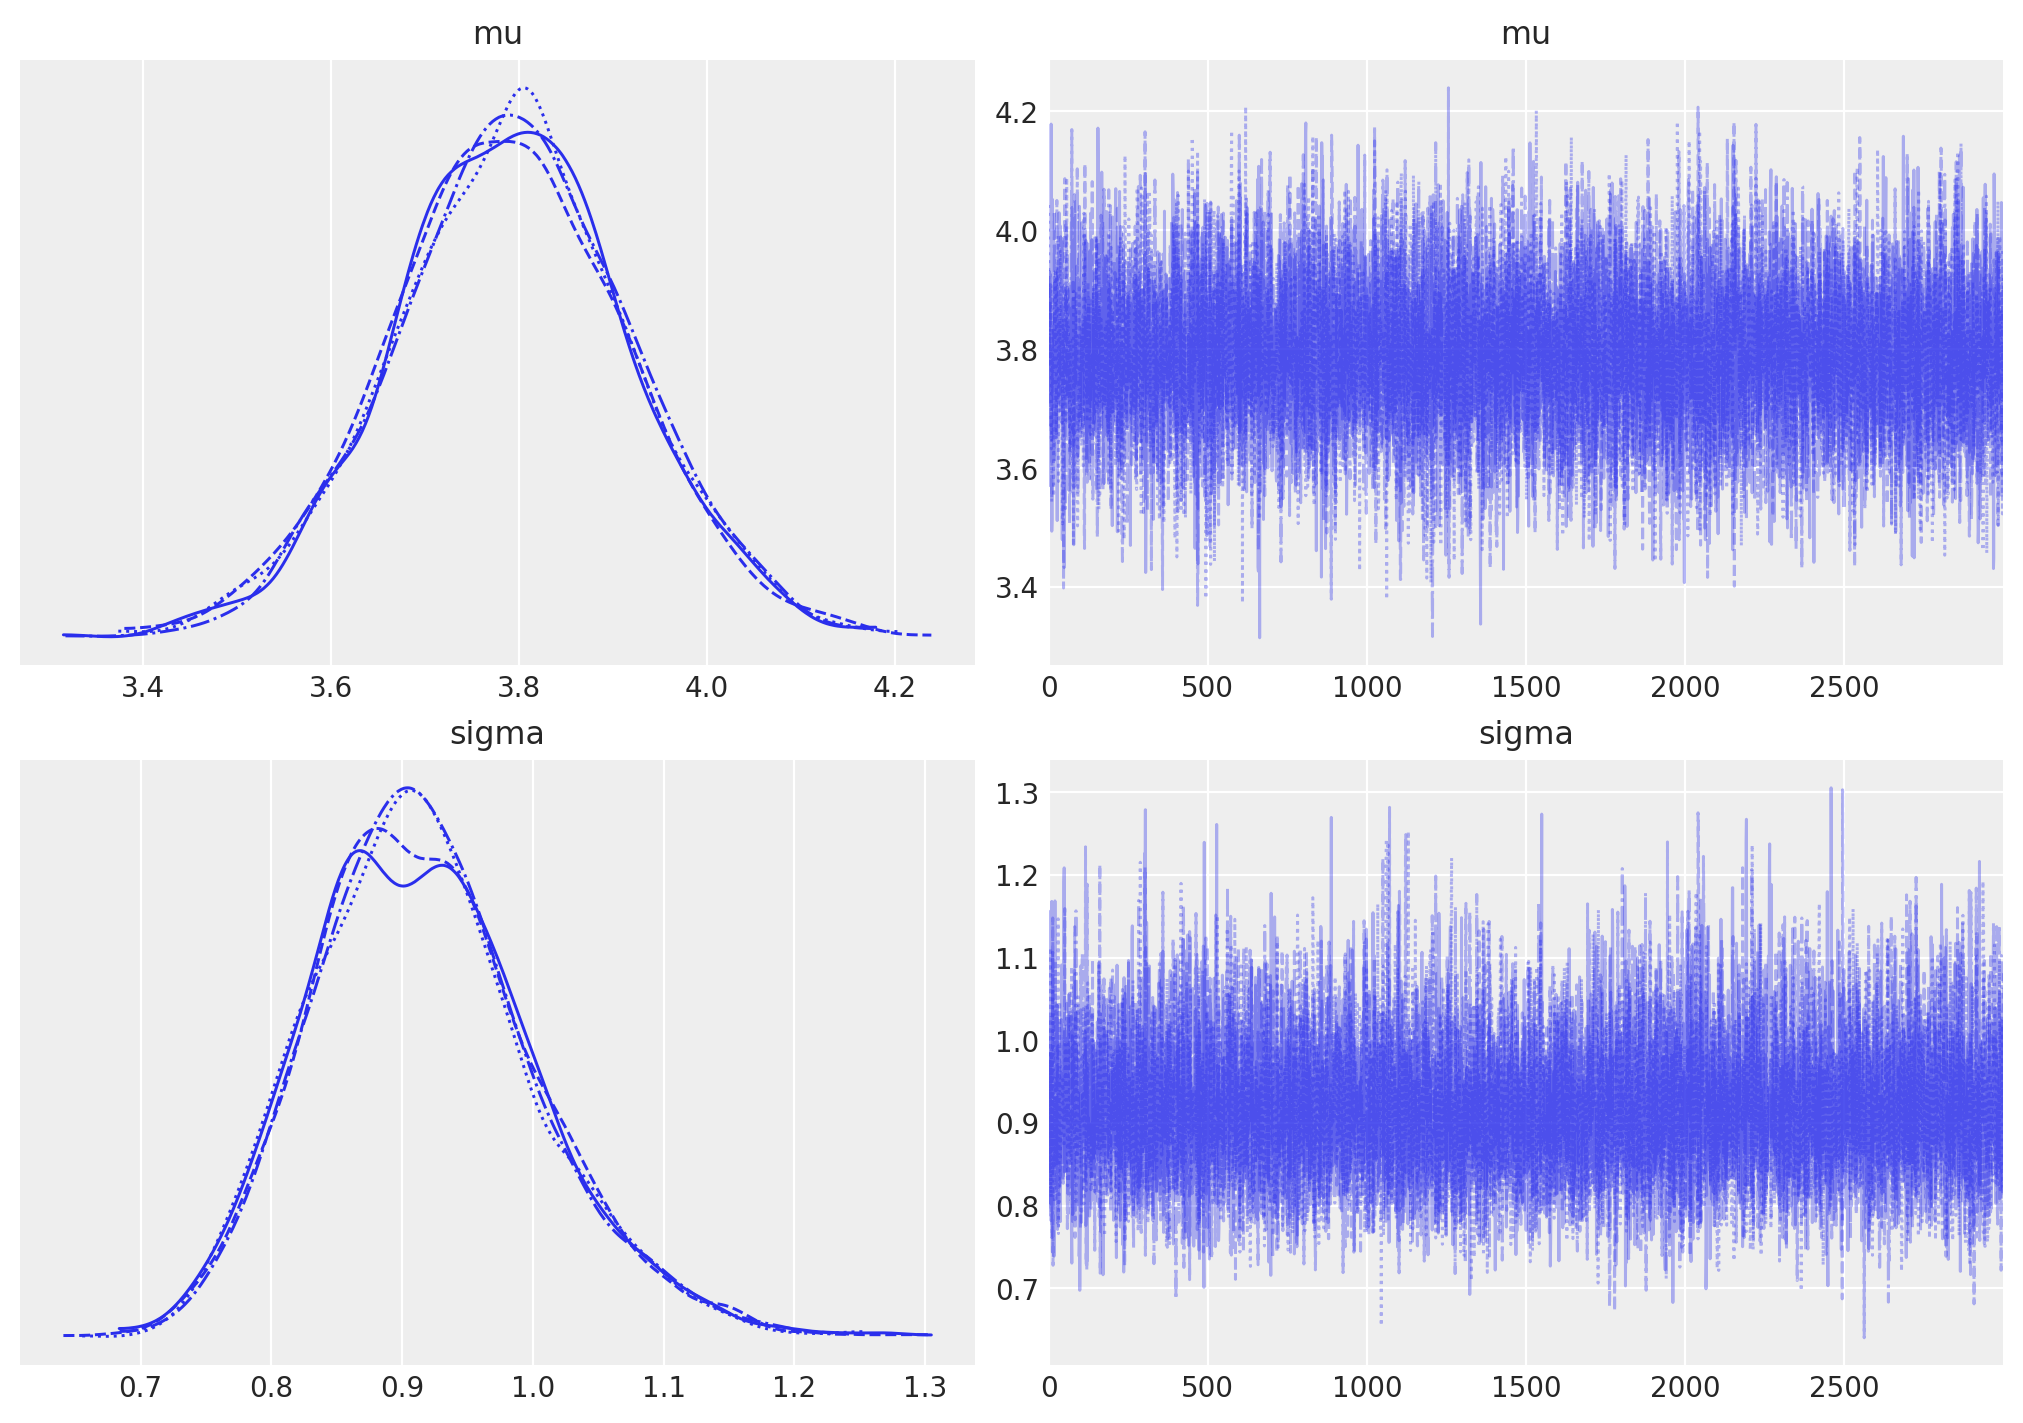

In [42]:
# Inference converged well

az.plot_trace(idata_0, var_names=['mu', 'sigma'], figsize=(10, 7));

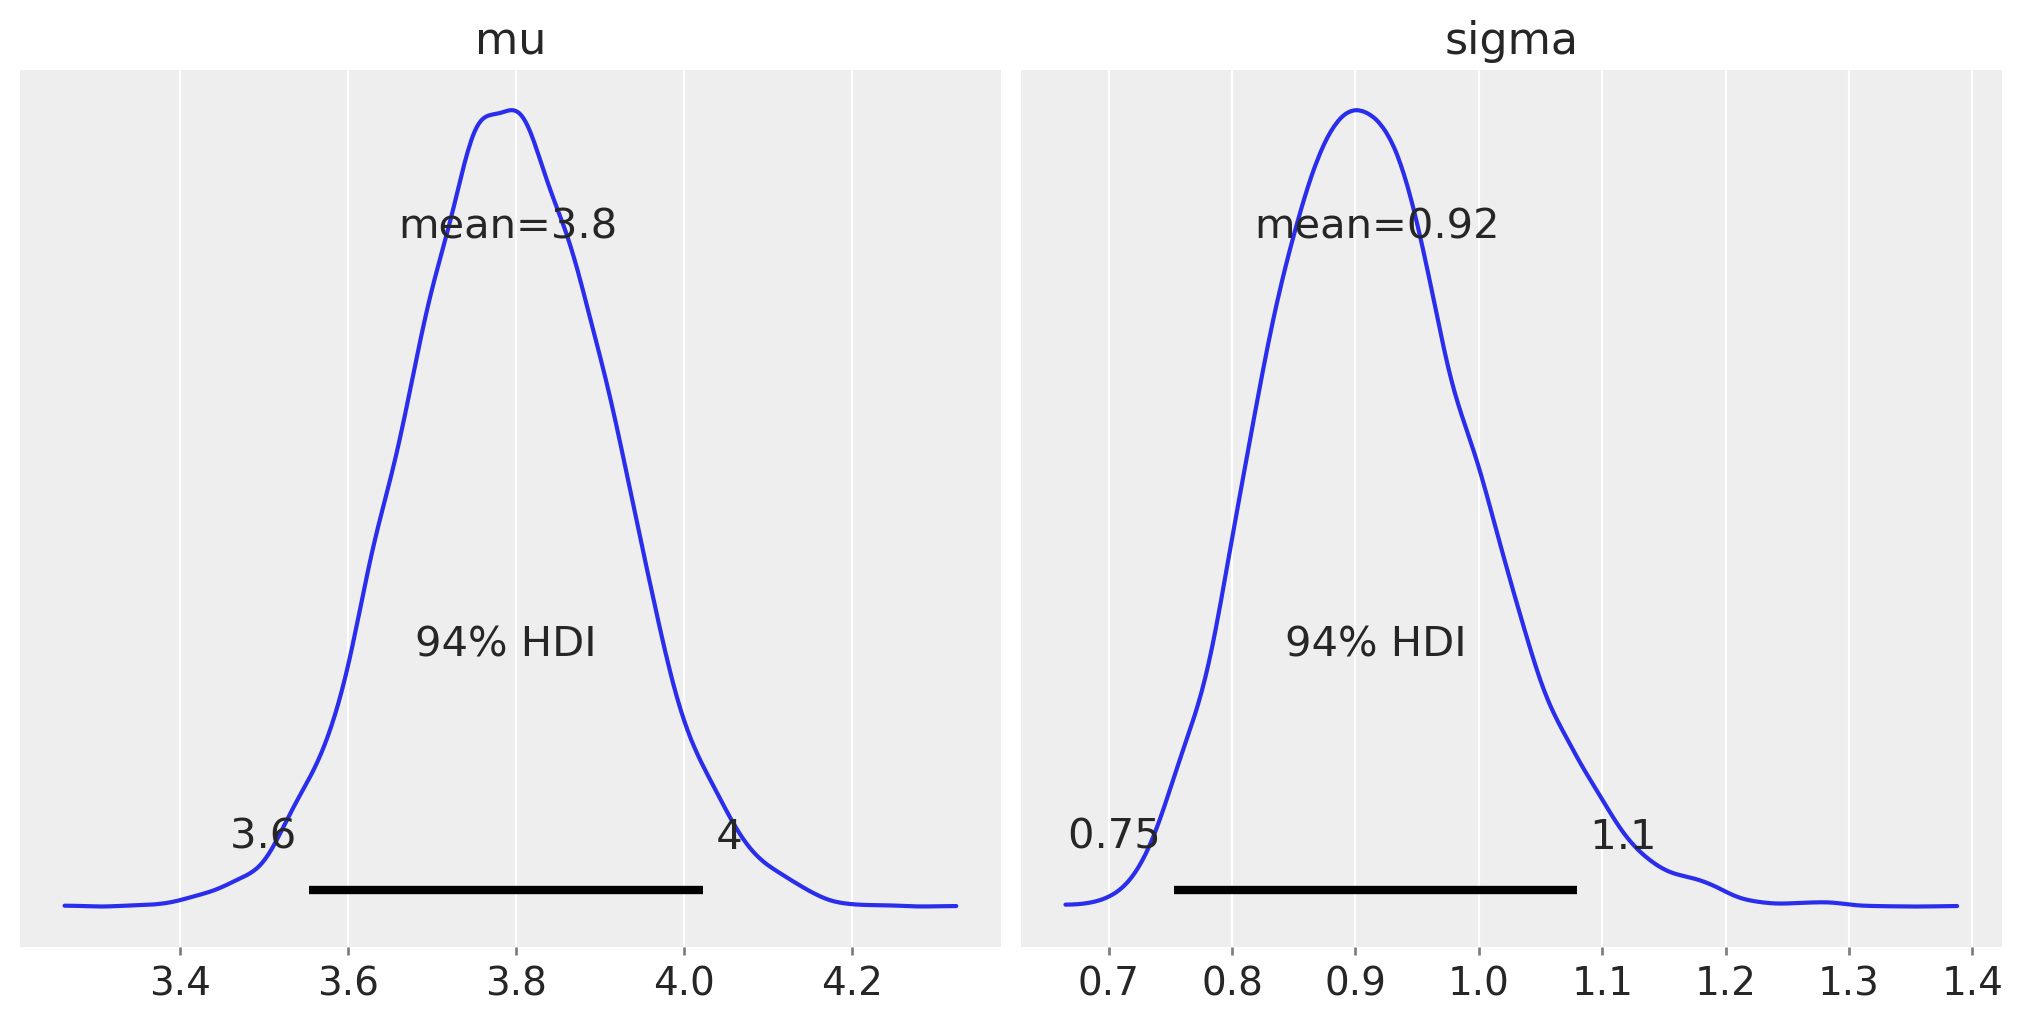

In [19]:
# Plot posterior with HDI

az.plot_posterior(idata_0, var_names=['mu', 'sigma'], figsize=(10, 5), hdi_prob=0.94, point_estimate='mean');

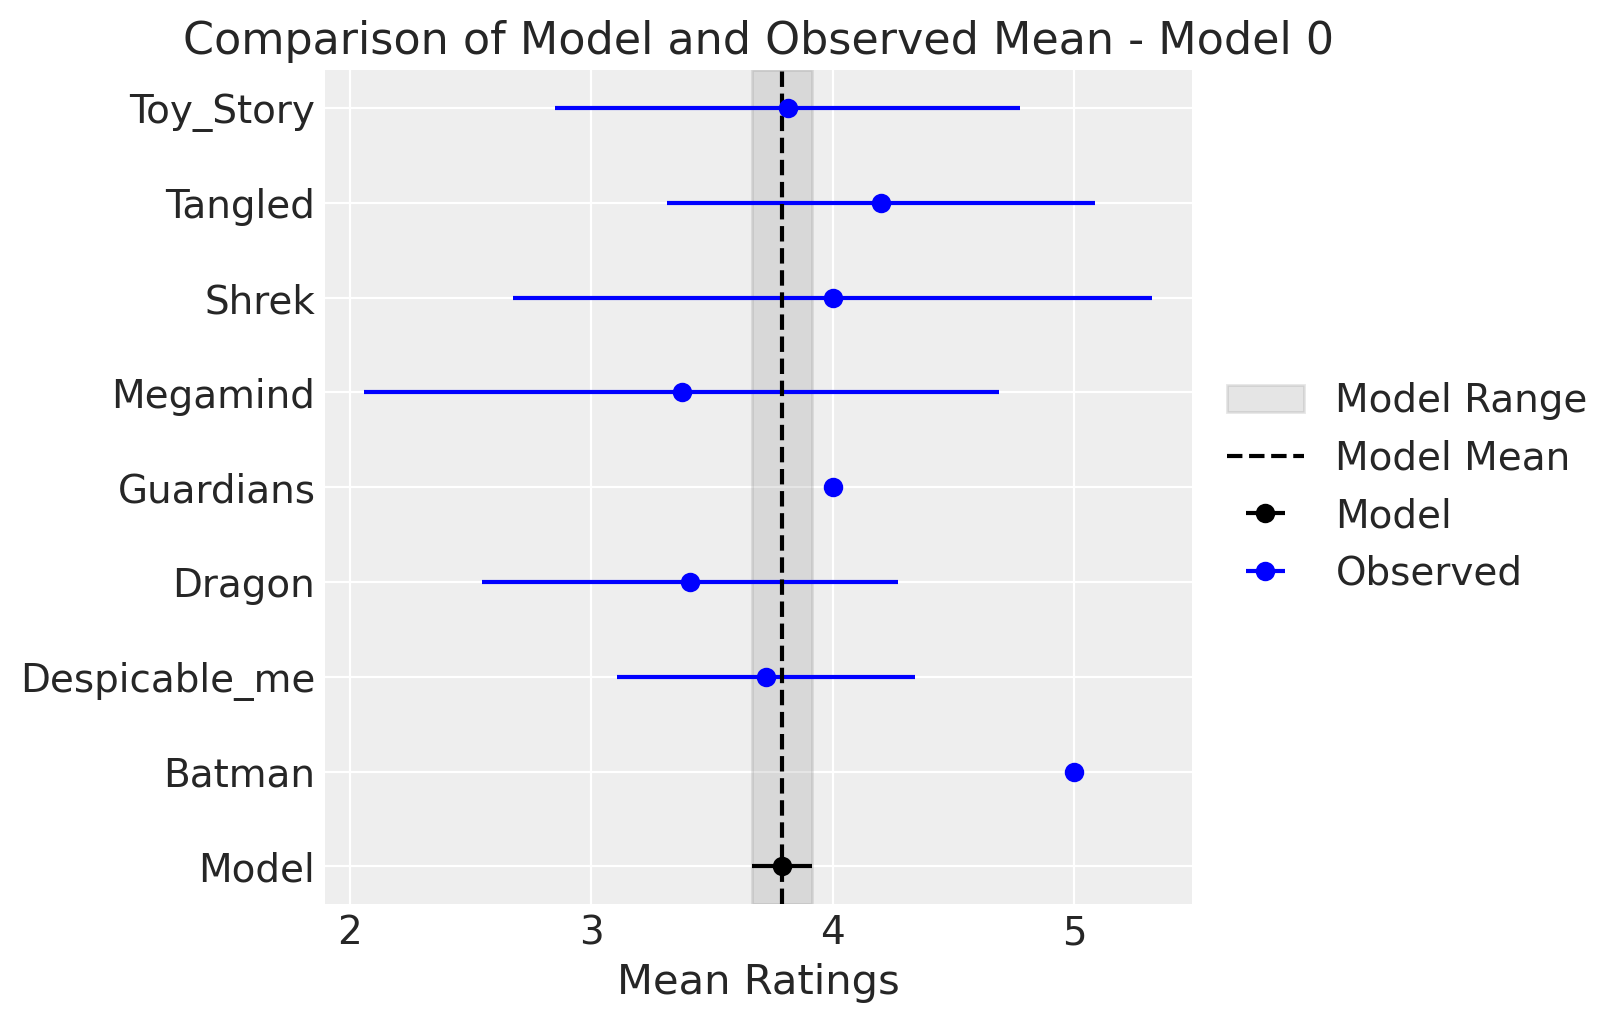

In [28]:
# Create indices for the plot
indices = np.arange(len(observed_stats) + 1)

fig, ax = plt.subplots(figsize=(8, 5))

# Plot model statistics
ax.errorbar(summary_0.loc['mu', 'mean'], indices[0], xerr=summary_0.loc['mu', 'sd'], fmt='o', label='Model', color='black')

# Plot observed statistics for each movie
ax.errorbar(observed_stats['mean'], indices[1:], xerr=observed_stats['std'], fmt='o', label='Observed', color='blue')

# Adding a vertical shaded band for the model range
ax.axvspan(summary_0.loc['mu', 'mean'] - summary_0.loc['mu', 'sd'], summary_0.loc['mu', 'mean'] + summary_0.loc['mu', 'sd'], color='gray', alpha=0.2, label='Model Range')
# Adding a vertical line for the model mean
ax.axvline(summary_0.loc['mu', 'mean'], color='black', linestyle='--', label='Model Mean')

ax.set_yticks(indices)
ax.set_yticklabels(['Model'] + observed_stats['title'].tolist())
ax.set_xlabel('Mean Ratings')
ax.set_title('Comparison of Model and Observed Mean - Model 0')

# Place the legend outside the plot on the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

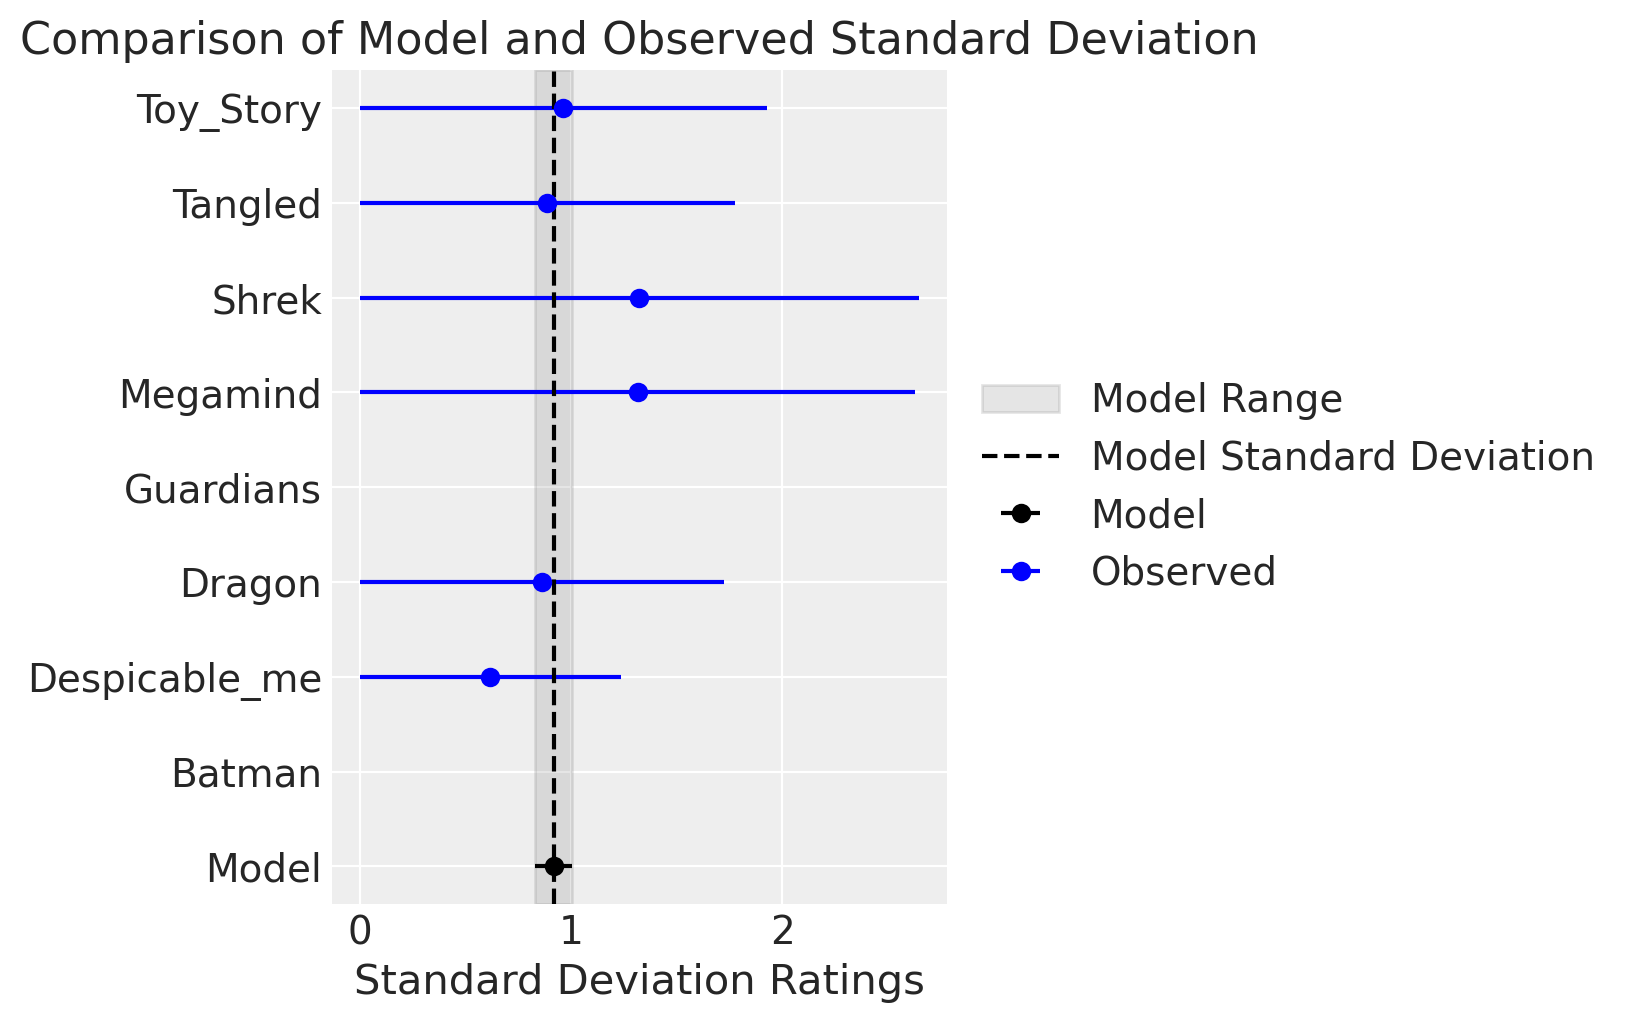

In [29]:
# Create indices for the plot
indices = np.arange(len(observed_stats) + 1)

fig, ax = plt.subplots(figsize=(8, 5))

# Plot model statistics
ax.errorbar(summary_0.loc['sigma', 'mean'], indices[0], xerr=summary_0.loc['sigma', 'sd'], fmt='o', label='Model', color='black')

# Plot observed statistics for each movie
ax.errorbar(observed_stats['std'], indices[1:], xerr=observed_stats['std'], fmt='o', label='Observed', color='blue')

# Adding a vertical shaded band for the model range
ax.axvspan(summary_0.loc['sigma', 'mean'] - summary_0.loc['sigma', 'sd'], summary_0.loc['sigma', 'mean'] + summary_0.loc['sigma', 'sd'], color='gray', alpha=0.2, label='Model Range')
# Adding a vertical line for the model mean
ax.axvline(summary_0.loc['sigma', 'mean'], color='black', linestyle='--', label='Model Standard Deviation')

ax.set_yticks(indices)
ax.set_yticklabels(['Model'] + observed_stats['title'].tolist())
ax.set_xlabel('Standard Deviation Ratings')
ax.set_title('Comparison of Model and Observed Standard Deviation')

# Place the legend outside the plot on the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Hierarchical Model 1

In [87]:
from pymc import Model, Normal, Gamma, Deterministic, sample, HalfNormal, InverseGamma

with Model() as model_1:
    # Define Stage 2 priors - Hyperprior
    mu_hyperprior = Normal("mu_hyperprior", mu=3, sigma=1)               # In general, use weakly informative priors on stage 2 hyperpriors
    sigma_hyperprior = InverseGamma('sigma_hyperprior', alpha=2, beta=1) # In general, use weakly informative priors on stage 2 hyperpriors

    # Define Stage 1 priors
    mu_i = Normal("mu_i", mu=mu_hyperprior, sigma=sigma_hyperprior, shape=len(titles))
    sigma =  InverseGamma('sigma', alpha=4, beta=1)                      # Single sigma for all the movies

    # Define likelihood
    model = {}
    for i, title in enumerate(titles):
        model[title] = Normal(f'model_{title}', mu=mu_i[i], sigma=sigma, observed=title_to_ratings[title])  # Define a different model for each movie title

    # Inference!
    idata_1 = sample(3000, return_inferencedata=True, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_hyperprior, sigma_hyperprior, mu_i, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


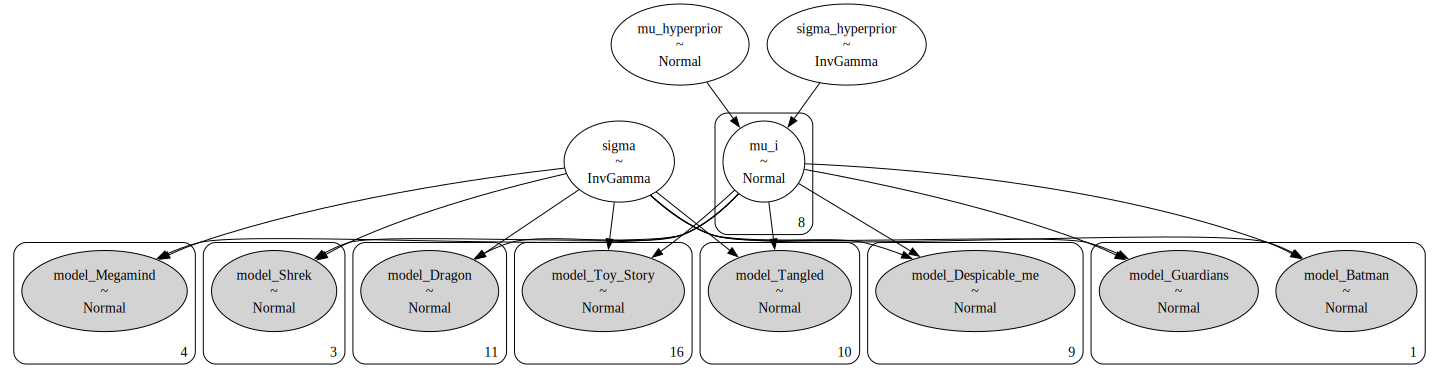

In [88]:
pm.model_to_graphviz(model_1)

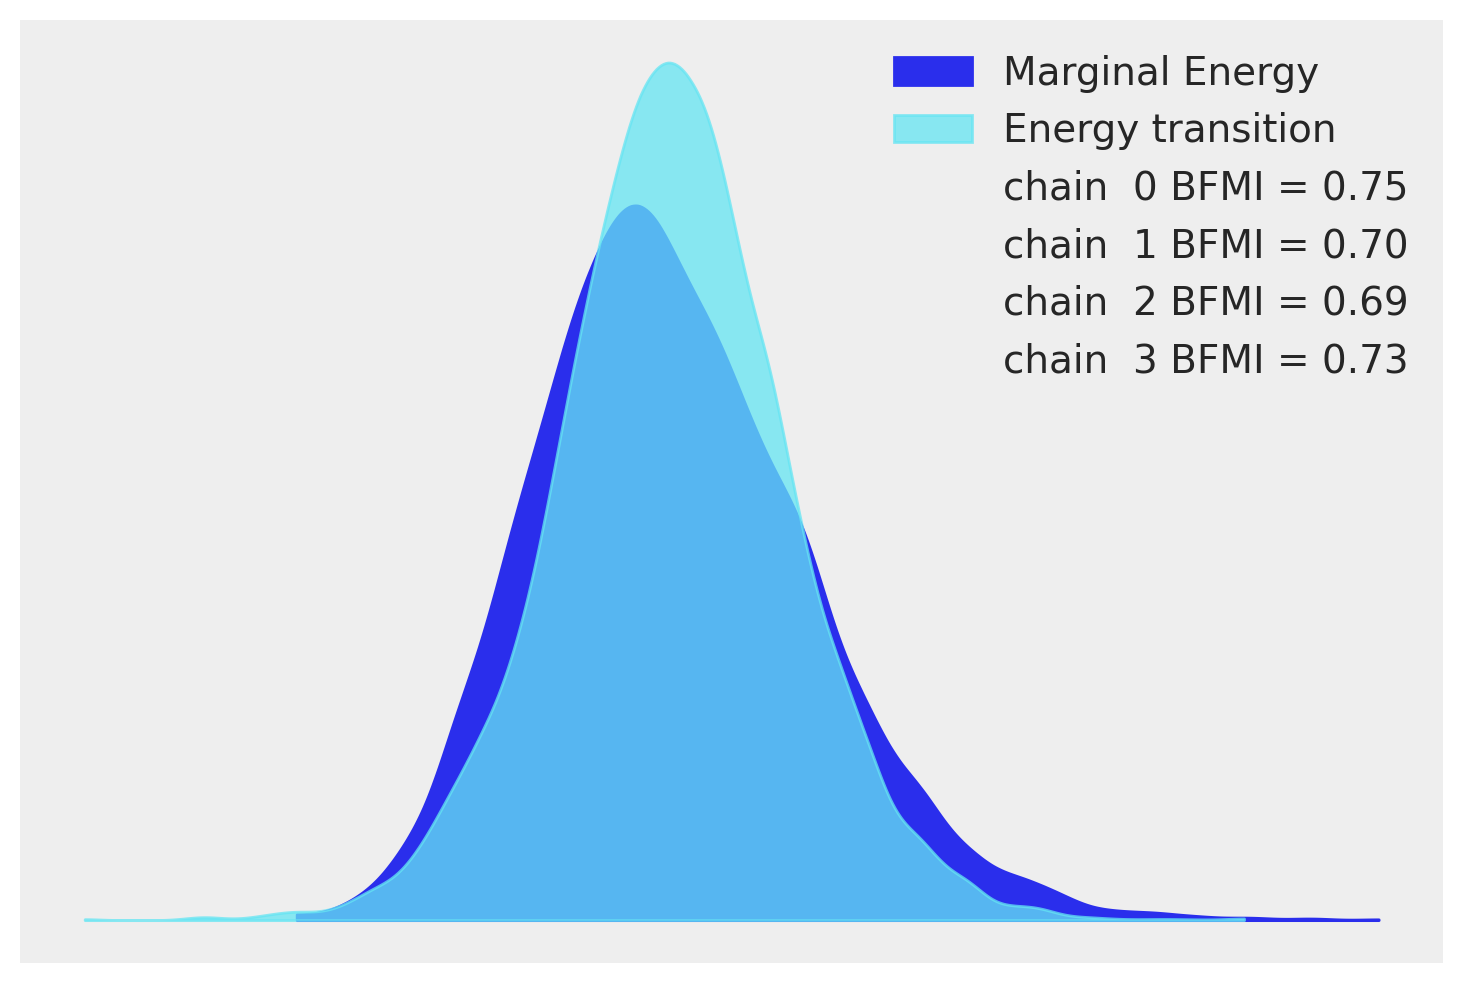

In [89]:
az.plot_energy(idata_1);

## Prior Predictive Check

In [90]:
# Prior predictive check

with model_1:
    prior_check_1 = pm.sample_prior_predictive(samples=1000)

Sampling: [model_Batman, model_Despicable_me, model_Dragon, model_Guardians, model_Megamind, model_Shrek, model_Tangled, model_Toy_Story, mu_hyperprior, mu_i, sigma, sigma_hyperprior]


In [91]:
# Dictionary to hold samples for each movie
samples_dict_1 = {}

for title in titles:
    key = f"model_{title.replace(' ', '_')}"  # Replace spaces with underscores if needed
    # Extract and flatten samples, store in dictionary
    samples_dict_1[title] = prior_check_1.prior_predictive[key].values.flatten()

/var/folders/3v/qbgbs1s16ds_0dymg_tpg8040000gn/T/ipykernel_2550/546666289.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


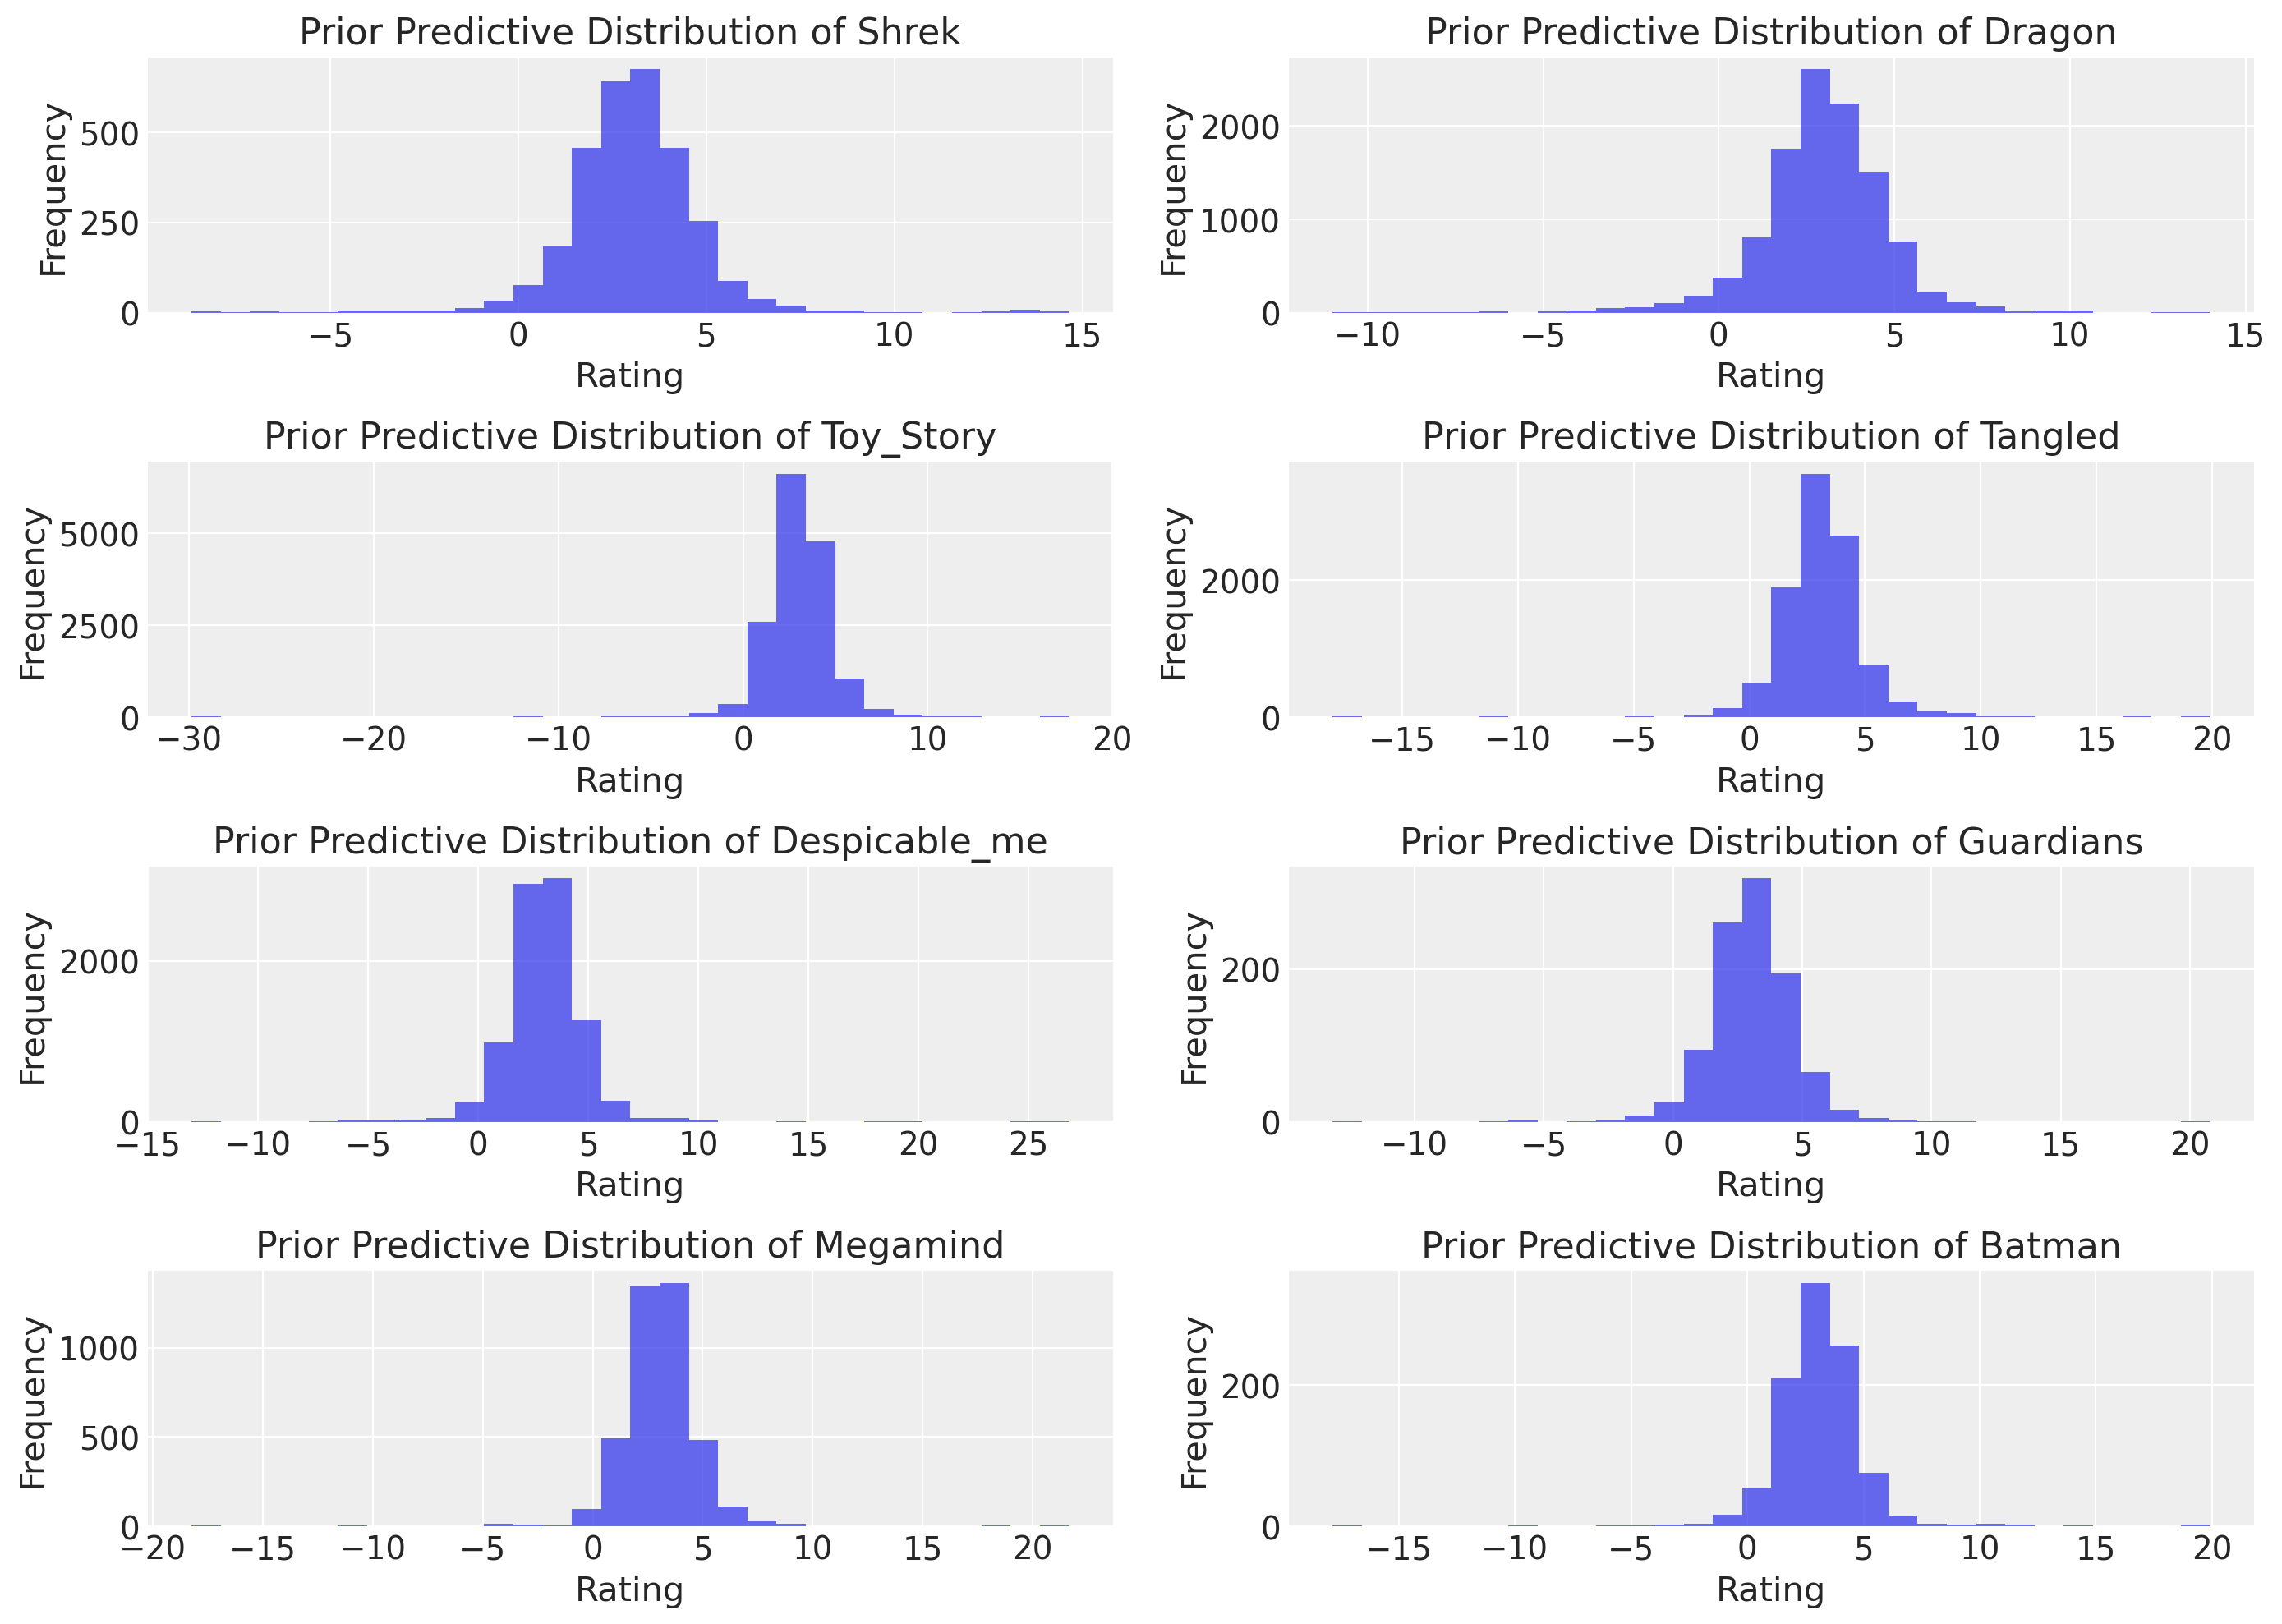

In [92]:
# Prepare the figure layout
plt.figure(figsize=(14, 10))  # Adjust the size as necessary

for i, title in enumerate(titles, 1):
    plt.subplot(4, 2, i)  # Adjust the grid dimensions based on the number of movies
    plt.hist(samples_dict_1[title], bins=30, alpha=0.7)  # Use the samples from the dictionary
    plt.title(f'Prior Predictive Distribution of {title}')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Posterior predictive checks

In [93]:
# Posterior predictive check

with model_1:
    posterior_check_1 = pm.sample_posterior_predictive(idata_1)

Sampling: [model_Batman, model_Despicable_me, model_Dragon, model_Guardians, model_Megamind, model_Shrek, model_Tangled, model_Toy_Story]


In [94]:
# Dictionary to hold samples for each movie
samples_posterior_1 = {}
observed = {}

for title in titles:
    key = f"model_{title.replace(' ', '_')}"  # Replace spaces with underscores if needed
    # Extract and flatten samples, store in dictionary
    samples_posterior_1[title] = posterior_check_1.posterior_predictive[key].values.flatten()
    observed[title] = posterior_check_1.observed_data[key].values.flatten()

/var/folders/3v/qbgbs1s16ds_0dymg_tpg8040000gn/T/ipykernel_2550/4113510519.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


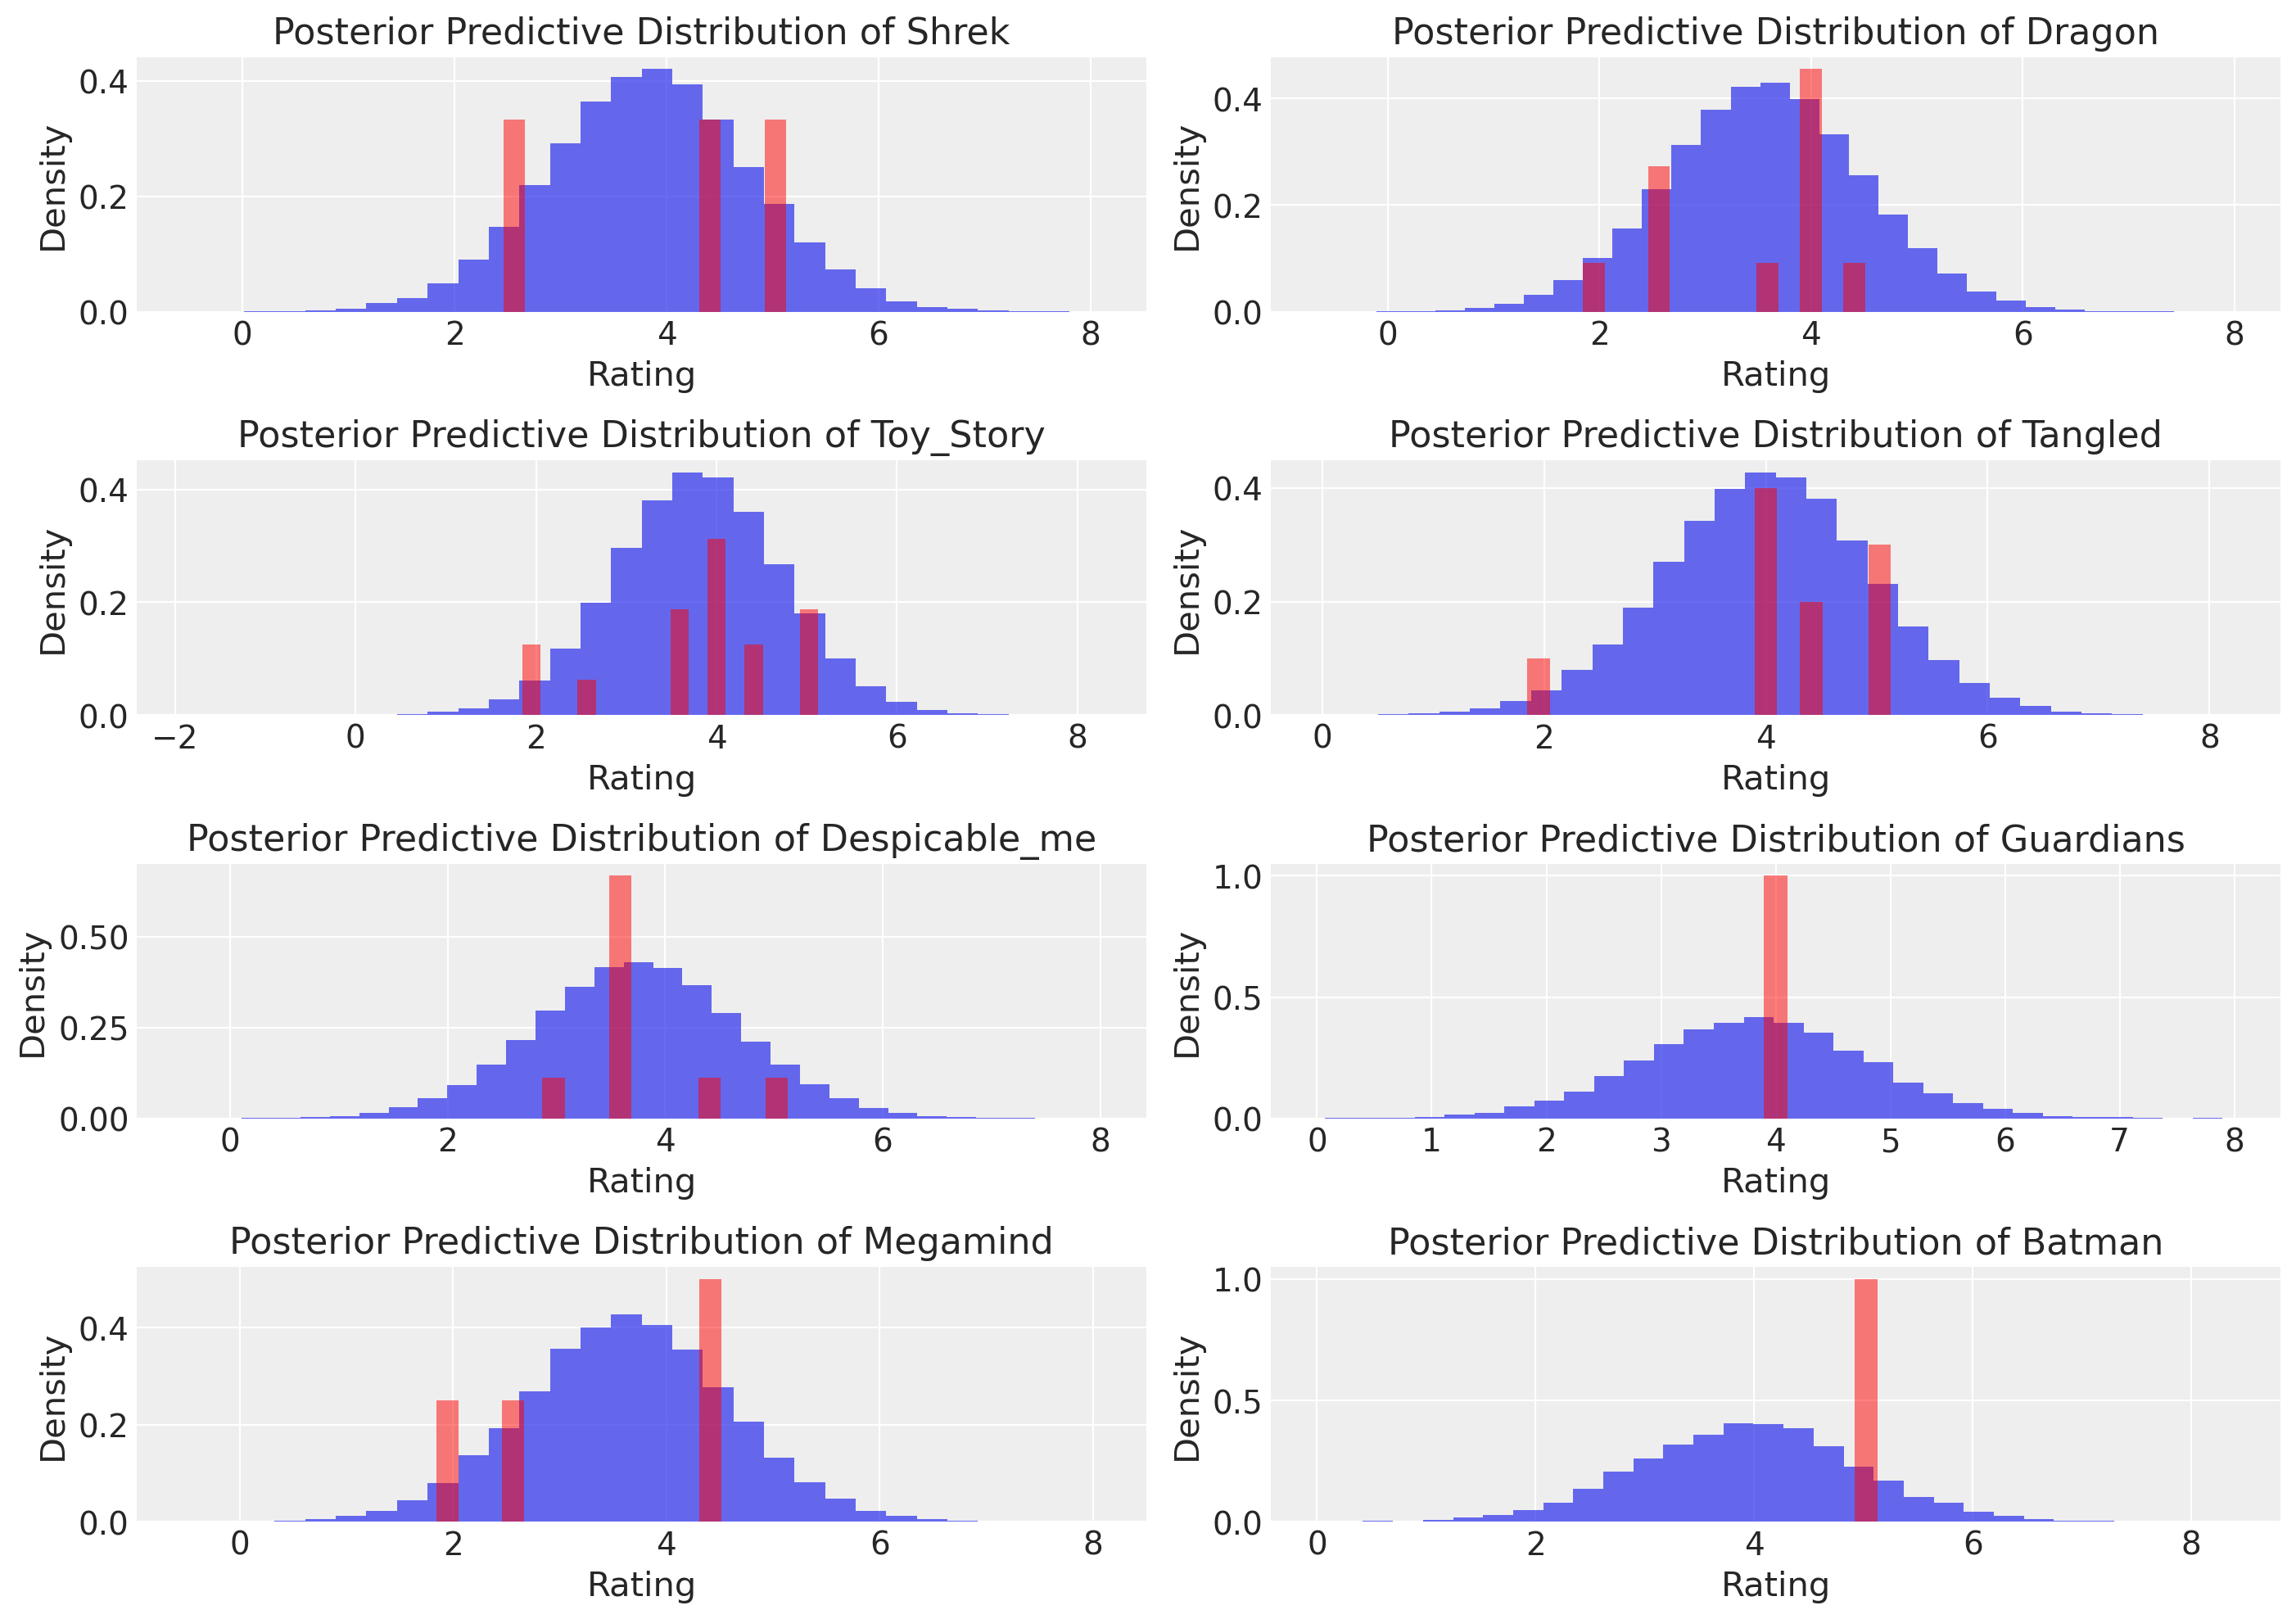

In [95]:
# Prepare the figure layout
plt.figure(figsize=(14, 10))  # Adjust the size as necessary

for i, title in enumerate(titles, 1):
    plt.subplot(4, 2, i)  # Adjust the grid dimensions based on the number of movies
    plt.hist(samples_posterior_1[title], bins=30, alpha=0.7, density=True)  # Use the samples from the dictionary

    # Weights for observed data to normalize the histogram
    weights = np.ones_like(observed[title]) / len(observed[title])
    
    # Superimpose observed data
    #plt.hist(observed[title]/len(observed[title]), bins=30, alpha=0.5, label='Observed Data', color='red')

    # Plot the observed data with normalization
    plt.hist(observed[title], bins=bins, weights=weights, alpha=0.5, color='red', label='Observed Data')


    plt.title(f'Posterior Predictive Distribution of {title}')
    plt.xlabel('Rating')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Inference

In [96]:
# Check the trace summary for results

summary_1 = pm.summary(idata_1)
summary_1

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_hyperprior     3.785  0.194   3.424    4.148      0.002    0.002    6207.0   
mu_i[0]           3.849  0.316   3.241    4.449      0.003    0.002    8372.0   
mu_i[1]           3.568  0.227   3.126    3.978      0.002    0.002    9436.0   
mu_i[2]           3.803  0.193   3.437    4.156      0.002    0.001    9404.0   
mu_i[3]           4.015  0.241   3.567    4.465      0.003    0.002    6837.0   
mu_i[4]           3.752  0.233   3.304    4.187      0.002    0.002   10258.0   
mu_i[5]           3.814  0.375   3.125    4.556      0.004    0.003    9638.0   
mu_i[6]           3.637  0.299   3.052    4.180      0.003    0.002    9201.0   
mu_i[7]           3.957  0.393   3.240    4.743      0.005    0.003    7560.0   
sigma             0.899  0.088   0.741    1.066      0.001    0.001   10002.0   
sigma_hyperprior  0.349  0.156   0.112    0.621      0.003    0.002    2863.0   

                  ess_tail  r_hat  
mu_hyperprior       7889.0    1.0  
mu_i[0]             8353.0    1.0  
mu_i[1]             8630.0    1.0  
mu_i[2]             7594.0    1.0  
mu_i[3]             7744.0    1.0  
mu_i[4]             8103.0    1.0  
mu_i[5]             7696.0    1.0  
mu_i[6]             7935.0    1.0  
mu_i[7]             6496.0    1.0  
sigma               7547.0    1.0  
sigma_hyperprior    4477.0    1.0

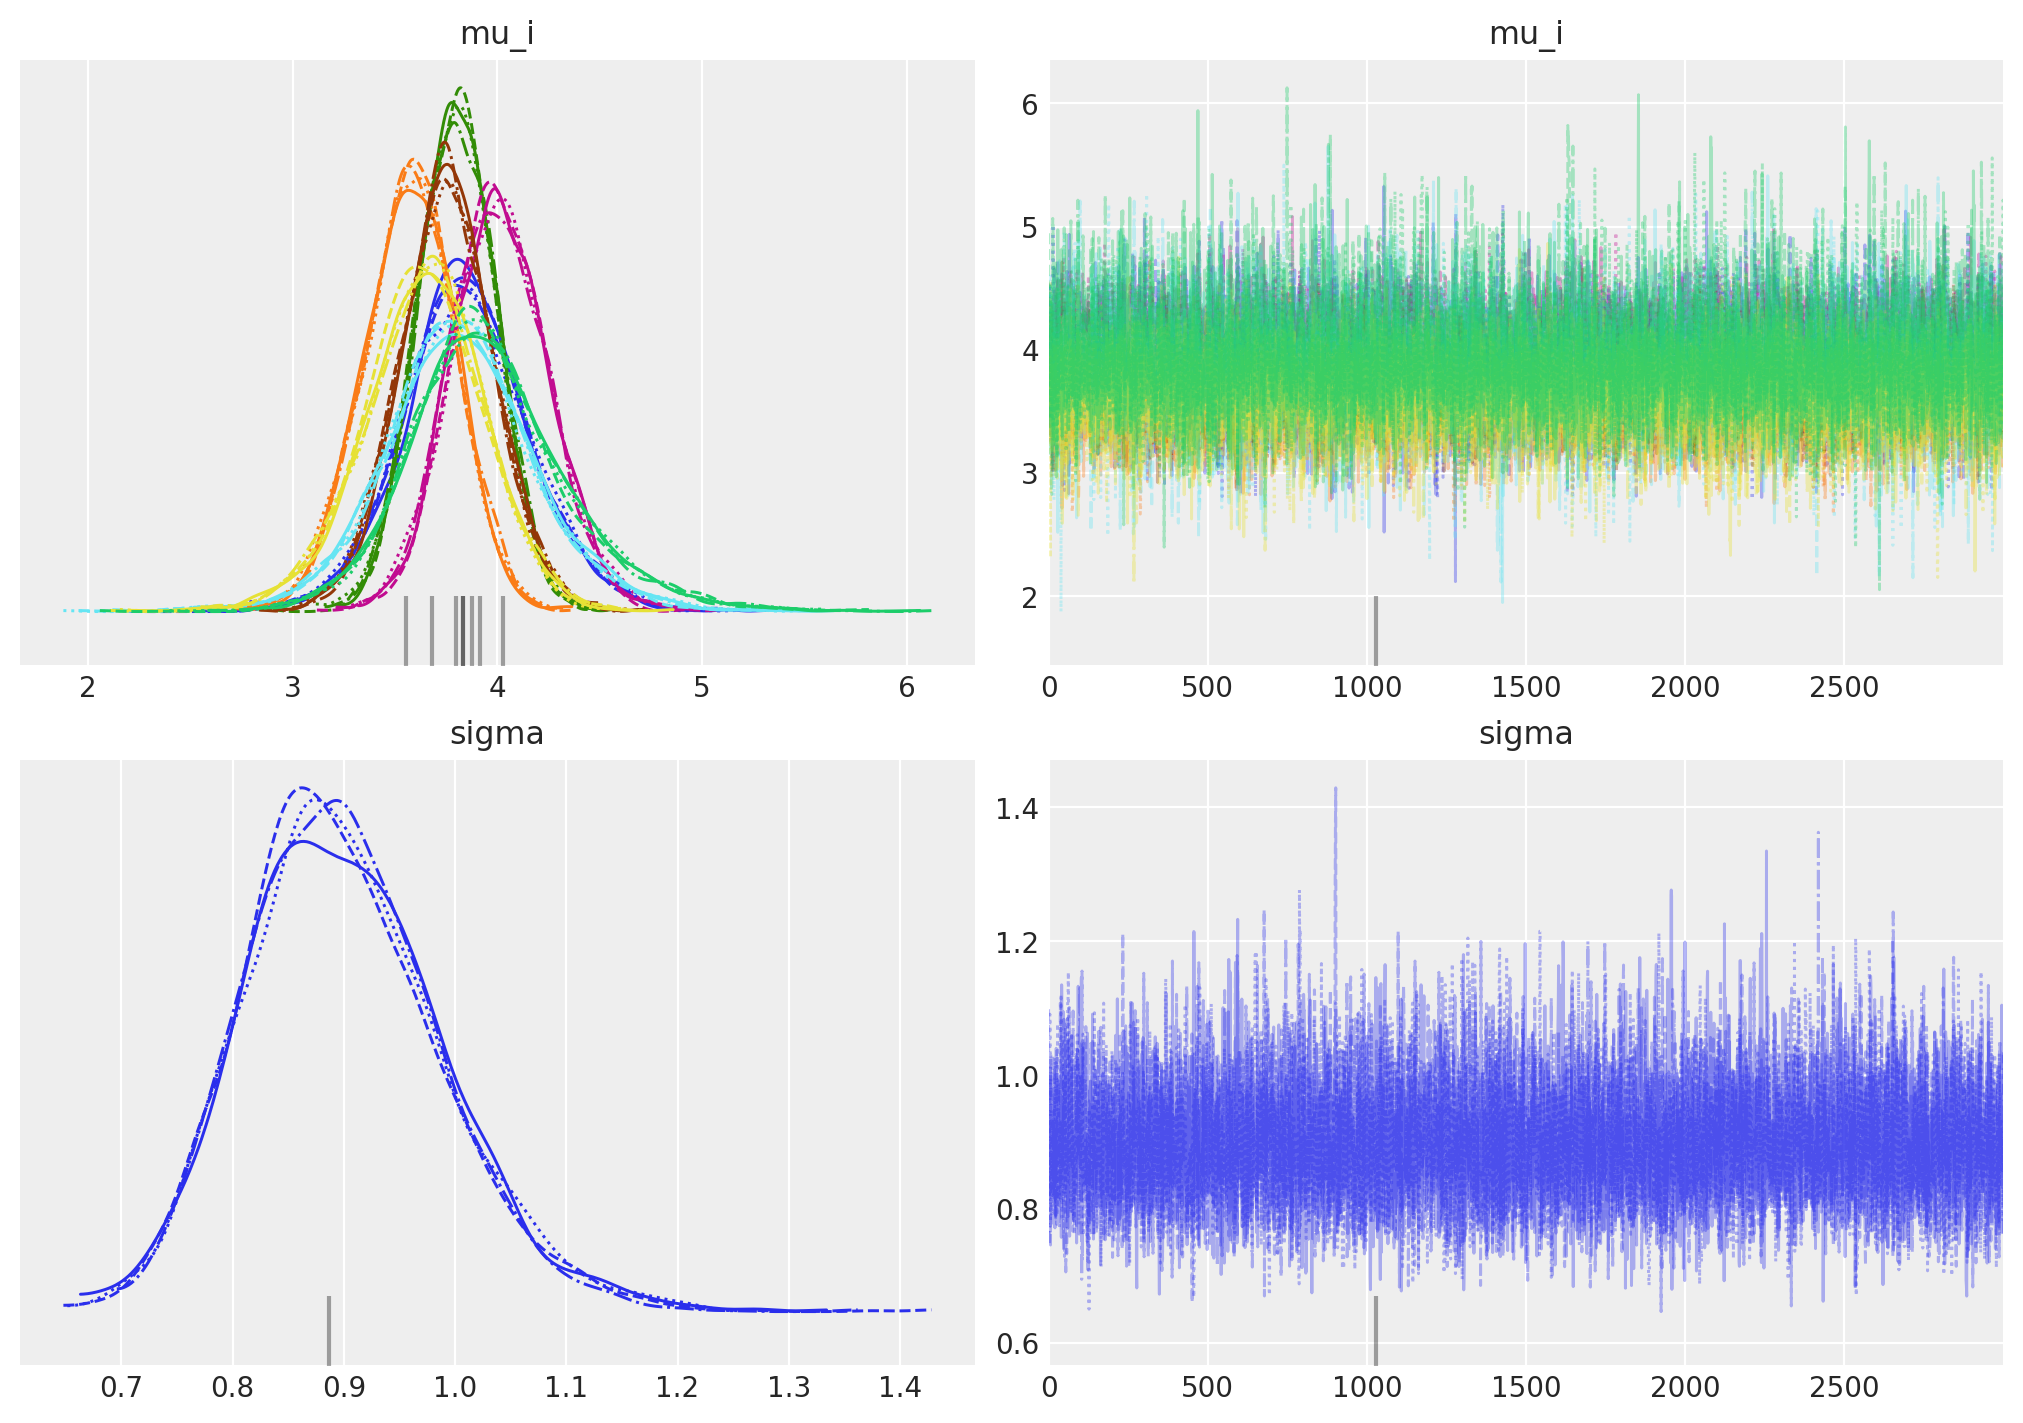

In [97]:
az.plot_trace(idata_1, var_names=['mu_i', 'sigma'], figsize=(10, 7));

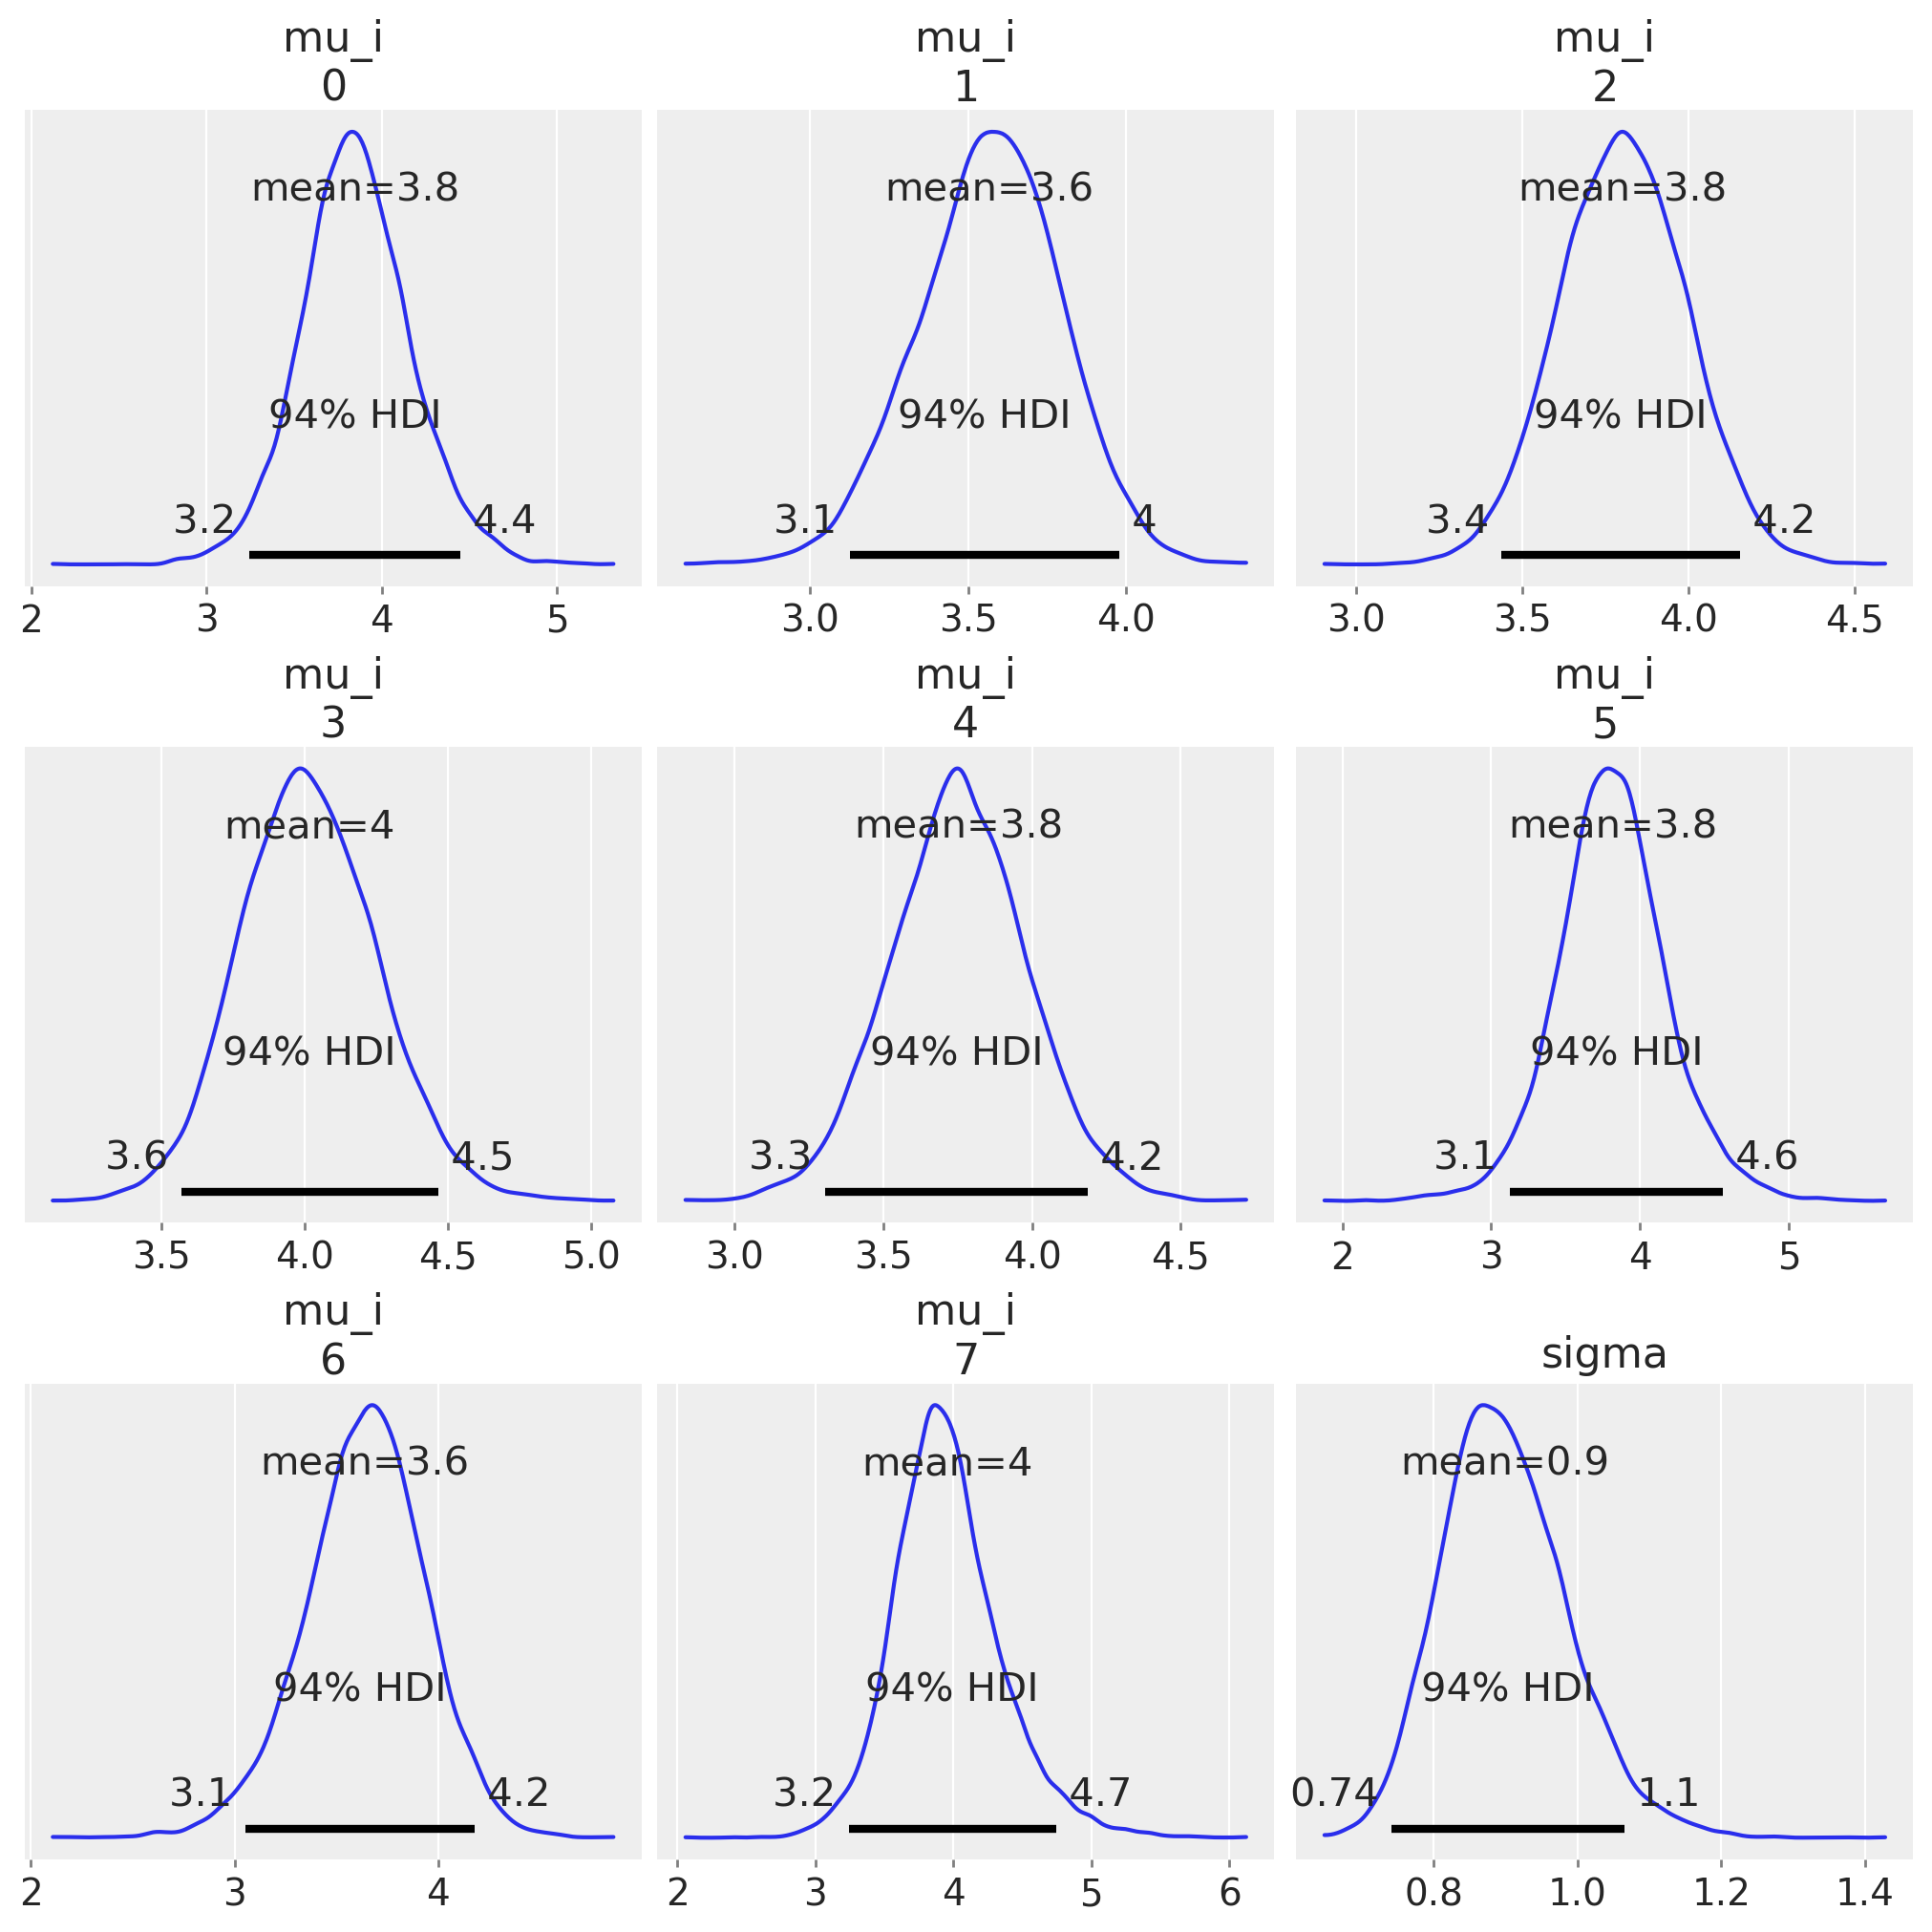

In [98]:
az.plot_posterior(idata_1, var_names=['mu_i', 'sigma'], figsize=(10, 10), hdi_prob=0.94, point_estimate='mean');

/var/folders/3v/qbgbs1s16ds_0dymg_tpg8040000gn/T/ipykernel_2550/2158756148.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


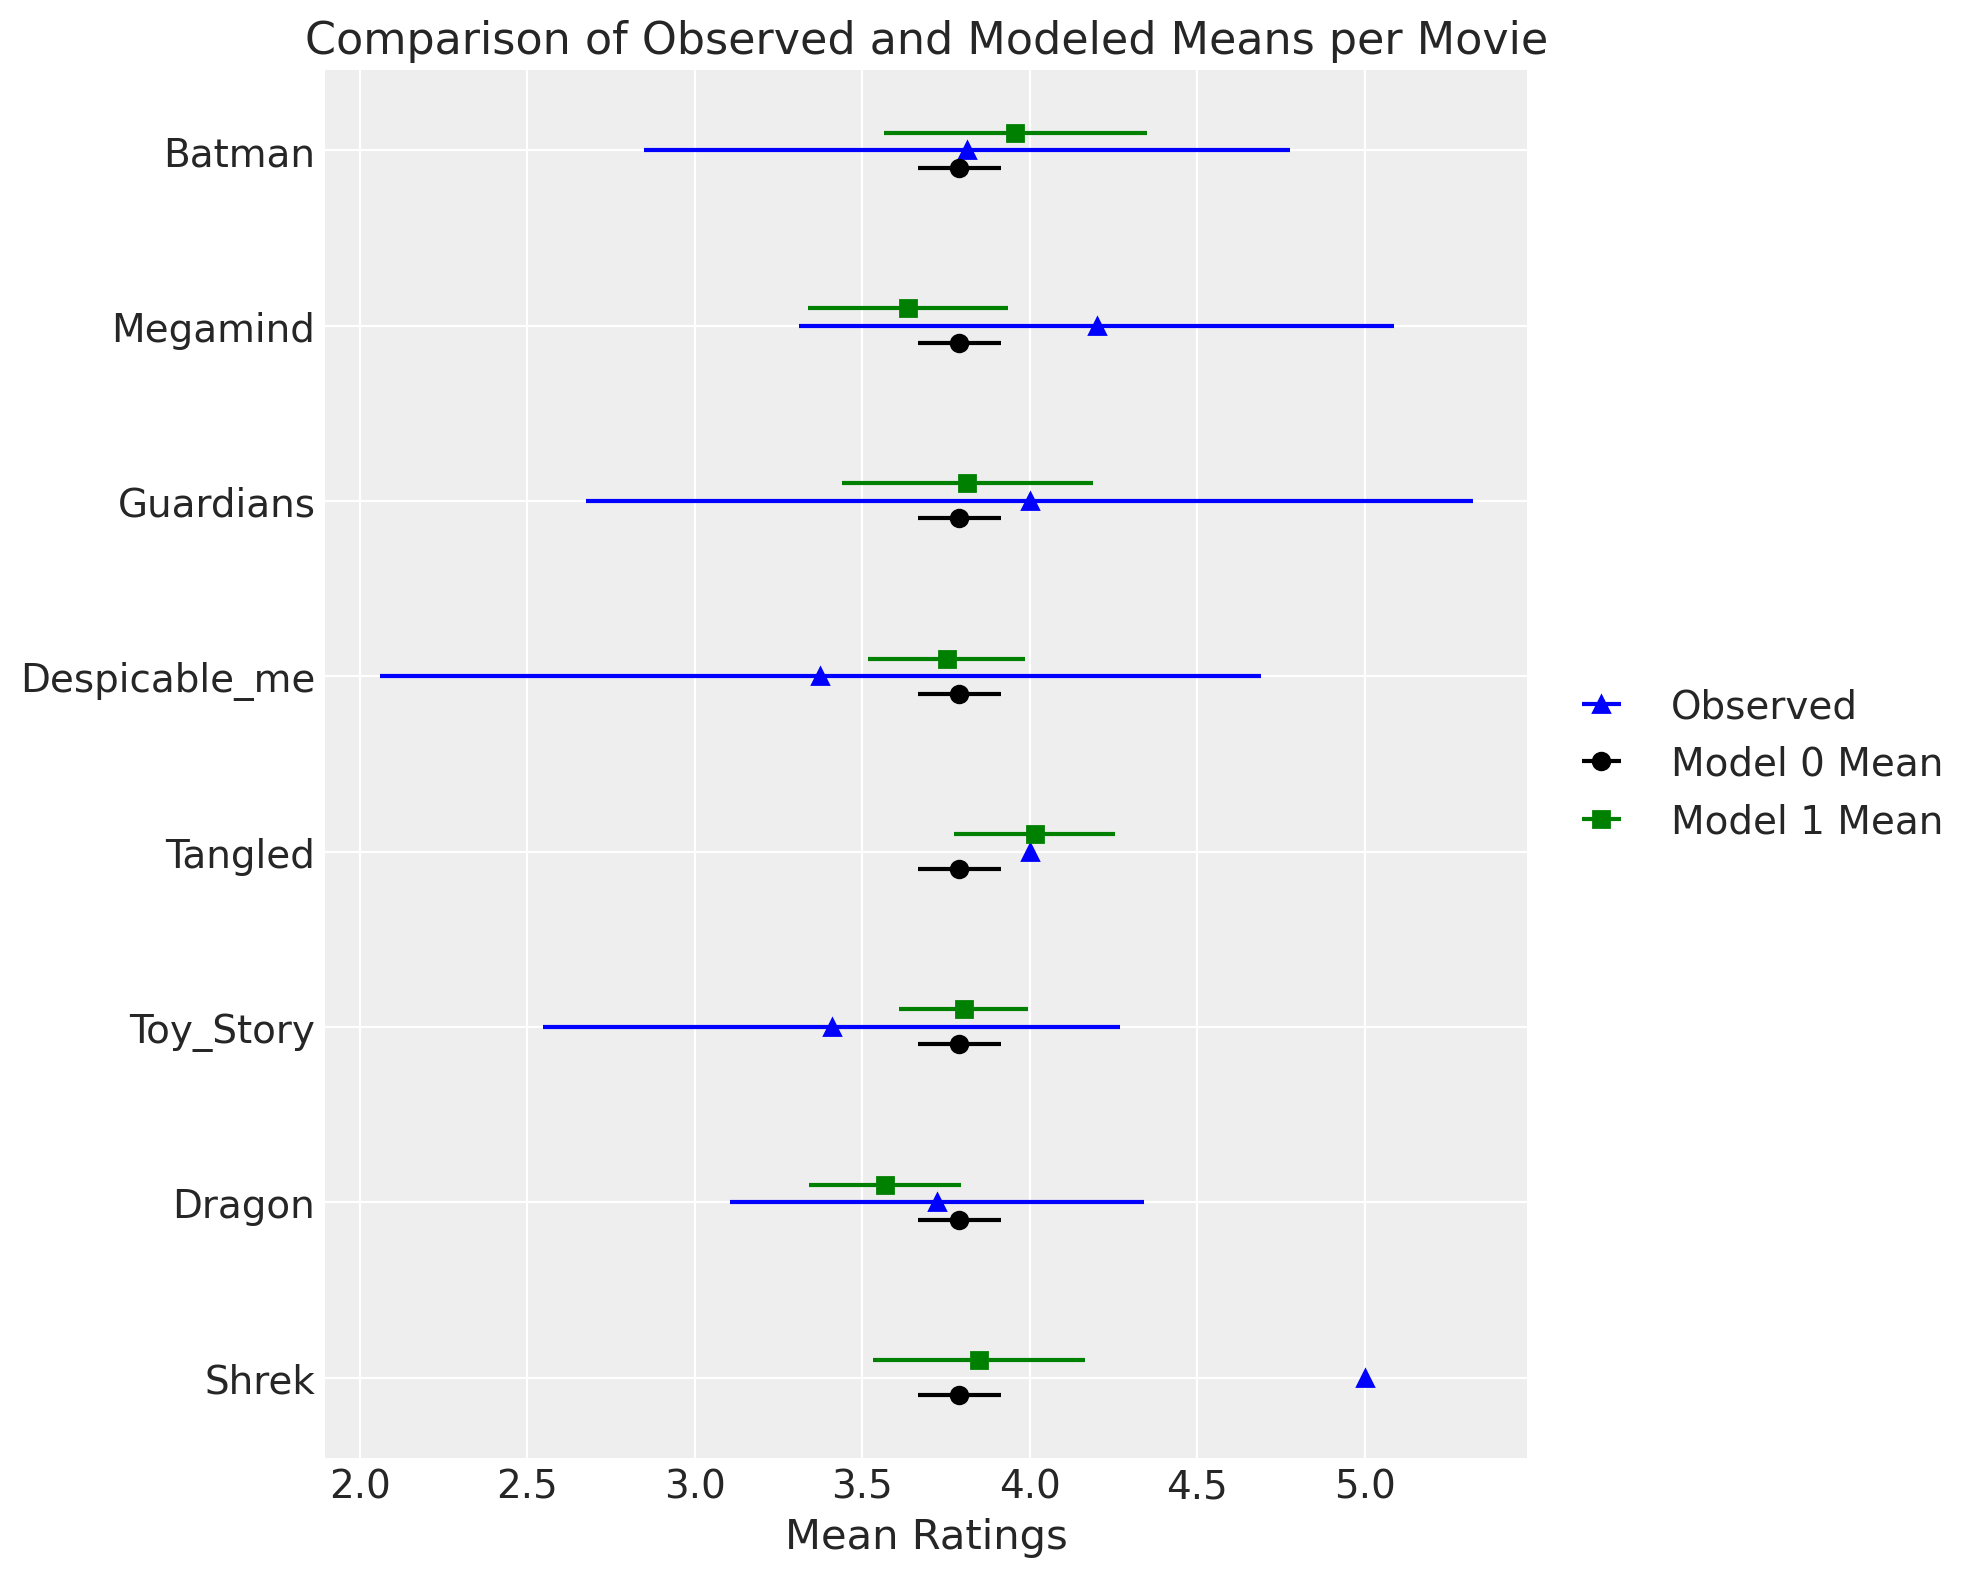

In [99]:
# Create indices for each movie
base_indices = np.arange(len(titles))

fig, ax = plt.subplots(figsize=(10, 8))

# Offsets for separating the groups vertically
offset = 0.1  # Adjust the offset size if needed
obs_indices = base_indices
model_0_indices = base_indices - offset  # Shift Model 0 slightly up
model_1_indices = base_indices + offset  # Shift Model 1 slightly down

# Plot observed statistics for each movie
ax.errorbar(observed_stats['mean'], obs_indices, xerr=observed_stats['std'], fmt='^', label='Observed', color='blue')

# Plot model 0 statistics (common mu for all movies)
model_0_mean = summary_0.loc['mu', 'mean']
model_0_std = summary_0.loc['mu', 'sd']
ax.errorbar([model_0_mean]*len(titles), model_0_indices, xerr=[model_0_std]*len(titles), fmt='o', label='Model 0 Mean', color='black')

# Plot model 1 statistics (individual mu for each movie)
model_1_means = summary_1.loc[['mu_i[{}]'.format(i) for i in range(len(titles))], 'mean']
model_1_stds = summary_1.loc[['mu_i[{}]'.format(i) for i in range(len(titles))], 'sd']
ax.errorbar(model_1_means, model_1_indices, xerr=model_1_stds, fmt='s', label='Model 1 Mean', color='green')

# Set labels and titles
ax.set_yticks(base_indices)
ax.set_yticklabels(titles)
ax.set_xlabel('Mean Ratings')
ax.set_title('Comparison of Observed and Modeled Means per Movie')

# Place the legend outside the plot on the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [100]:
summary_0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     3.790  0.124   3.554    4.023      0.001    0.001   10144.0    6846.0   
sigma  0.918  0.088   0.753    1.079      0.001    0.001   11522.0    8459.0   

       r_hat  
mu       1.0  
sigma    1.0

In [101]:
summary_1

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_hyperprior     3.785  0.194   3.424    4.148      0.002    0.002    6207.0   
mu_i[0]           3.849  0.316   3.241    4.449      0.003    0.002    8372.0   
mu_i[1]           3.568  0.227   3.126    3.978      0.002    0.002    9436.0   
mu_i[2]           3.803  0.193   3.437    4.156      0.002    0.001    9404.0   
mu_i[3]           4.015  0.241   3.567    4.465      0.003    0.002    6837.0   
mu_i[4]           3.752  0.233   3.304    4.187      0.002    0.002   10258.0   
mu_i[5]           3.814  0.375   3.125    4.556      0.004    0.003    9638.0   
mu_i[6]           3.637  0.299   3.052    4.180      0.003    0.002    9201.0   
mu_i[7]           3.957  0.393   3.240    4.743      0.005    0.003    7560.0   
sigma             0.899  0.088   0.741    1.066      0.001    0.001   10002.0   
sigma_hyperprior  0.349  0.156   0.112    0.621      0.003    0.002    2863.0   

                  ess_tail  r_hat  
mu_hyperprior       7889.0    1.0  
mu_i[0]             8353.0    1.0  
mu_i[1]             8630.0    1.0  
mu_i[2]             7594.0    1.0  
mu_i[3]             7744.0    1.0  
mu_i[4]             8103.0    1.0  
mu_i[5]             7696.0    1.0  
mu_i[6]             7935.0    1.0  
mu_i[7]             6496.0    1.0  
sigma               7547.0    1.0  
sigma_hyperprior    4477.0    1.0

In [102]:
titles

array(['Shrek', 'Dragon', 'Toy_Story', 'Tangled', 'Despicable_me',
       'Guardians', 'Megamind', 'Batman'], dtype=object)